In [1]:
%matplotlib inline 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sunpy.time import parse_time
import sklearn
from sklearn import svm  
from sklearn import cross_validation
import os
from scipy import interpolate

# Create a train/test dataset for flare events

### Further clean up of GOES set
1) eliminate events of duration > 75th percentile 

2) eliminate events with data dropouts > 3 min

3) calculate more accurate peak times

In [ ]:
j = 0
cutoff = 1500
k = 0
durations = []
one_list = [1 for k in range(events.shape[0])]
events.loc[:, 'pass_duration'] = one_list
for elem in events['event_starttime']:
    duration = (((events['event_endtime'].values[j] - events['event_starttime'].values[j])*10**(-9))/
                np.timedelta64(1, 'ns'))
    durations.append(duration)
    if duration>=cutoff:
        events['pass_duration'].values[j]=0
    j+=1
prepped2 = events.ix[events['pass_duration']==1]
prepped2.to_csv('prepped_GOES2.csv', index=False, date_format = '%Y-%m-%dT%X')
_ = plt.hist(durations, bins=100, range = (0, 10000))

In [ ]:
percentile = [10, 25, 33, 50, 55, 60, 66, 75, 90]
np.percentile(durations, percentile)

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')


lightcurve_goes = pd.read_csv('raw_GOES_lightcurves.csv', delimiter = ',', header = 0,parse_dates=['date'],
                              date_parser=dateparse, usecols = ['date', 'xrsb'])

In [5]:
length = lightcurve_goes.shape[0]
i1 = length/4
i2 = i1 - 1500
i3 = length/2
i4 = i3 -1500
i5 = length*3/4
i6 = i5 - 1500
lcg3 = lightcurve_goes.iloc[i4:i5,:]
lcg3.to_csv('lightcurve_goes_3.csv', index=0, date_format = '%Y-%m-%dT%X')

In [3]:
listOdataDrops = []
for root, dirs, files in os.walk('sklearn_goes_train_lc'):
    for f in files:
        if f[0] != '.':
            inputFile = 'sklearn_goes_train_lc' +'/'+f
            lc = pd.read_csv(inputFile, delimiter = ',', header=0)
            zeroStreak = False
            numZeroStreak = 0
            maxZeroStreak = 0
            i = 0
            bad_i = 0
            for elem in lc['xrsb']:
                if elem<=9*10**(-8):
                    numZeroStreak+=1
                    zeroStreak=True
                else: 
                    zeroStreak=False
                    numZeroStreak=0
                if numZeroStreak>=2:
                    if numZeroStreak>maxZeroStreak:
                        maxZeroStreak=numZeroStreak
                        i = bad_i
            if maxZeroStreak>=2:
                listOdataDrops.append(f[:-4])
                print lc['date'].values[bad_i]
                print lc['date'].values[bad_i-1]
                print '-----'
                
            i+=1

print listOdataDrops   

2012-09-20T09:18:00
2012-09-20T09:25:59
-----
2015-06-05T09:25:00
2015-06-05T09:48:00
-----
2016-05-14T09:26:01
2016-05-14T09:34:00
-----
['SOL2012-09-20T09:18:00L302C112', 'SOL2015-06-05T09:25:00L102C075', 'SOL2016-05-14T09:26:00L359C096']


In [82]:
prepped2 = pd.read_csv('prepped_GOES.csv', delimiter=',', header=0, )
one_list = [1 for k in range(prepped2.shape[0])]
prepped2.loc[:, 'no_data_drop'] = one_list
i = 0
print listOdataDrops[0]
for elem in prepped2['SOL_standard']:
    if elem==listOdataDrops[0] or elem==listOdataDrops[1] or elem==listOdataDrops[2]:
        prepped2['no_data_drop'].values[i] = 0
        print elem
    i+=1
prepped3 = prepped2.ix[prepped2['no_data_drop']==1]
print len(prepped3)

SOL2012-09-20T09:18:00L302C112
SOL2011-03-01T14:35:00L160C064
SOL2011-03-01T17:42:00L167C066
SOL2011-03-01T18:06:00L154C062
SOL2011-03-01T18:51:00L165C066
SOL2012-09-20T09:18:00L302C112
SOL2015-06-05T09:25:00L102C075
SOL2016-05-14T09:26:00L359C096
7311


In [7]:
peakfluxes = []
peaktimes = []
SOL_standards = []
i=0
for root, dirs, files in os.walk('sklearn_goes_all_lc'):
    for f in files:
        if f[0] != '.':
            inputFile = 'sklearn_goes_all_lc' +'/'+f
            lc = pd.read_csv(inputFile, delimiter = ',', header=0)
            maxidx = np.argmax(np.array(lc['xrsb']))
            peakflux = lc['xrsb'].values[maxidx]
            peaktime = lc['date'].values[maxidx]
            peakfluxes.append(peakflux)
            peaktimes.append(peaktime)
            SOL_standards.append(f[:-4])
            i+=1

dic = {'SOL_standard': SOL_standards, 'peaktime':peaktimes, 'peakflux': peakfluxes}
peaks = pd.DataFrame(dic)

peaks.to_csv('peaks_GOES_all.csv', index=False, date_format = '%Y-%m-%dT%X')


99


In [88]:
peaks['peaktime'] = map(parse_time, peaks['peaktime'])


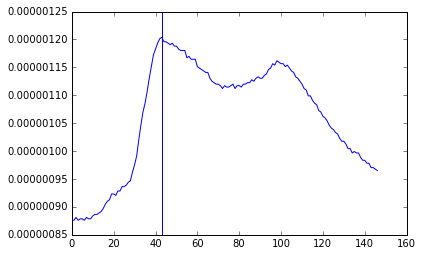

In [93]:
fname = 'sklearn_goes_train_lc/SOL2011-03-01T14_35_00L160C064.csv'
lc = pd.read_csv(fname, delimiter=',', header = 0)
plt.plot(lc['xrsb'])
plt.axvline(43)

In [66]:
test = prepped2[::36]

In [74]:
cgs = map(lambda x: x*10**4*10**7, peaks['peakflux'])
peaks.loc[:, 'peakflux_cgs'] = cgs

[-0.086302815475226821, -0.090495669393869771, -0.0045152005308095444, -0.15007282589911883, -0.0019960134365588572, -0.14268632436101242, -0.019211173893626976, -0.017193201266024759, -0.017775130934129968, -0.066628346968044622, -0.064411658536800281, -0.037662382120210891, -0.018150718067146514, -0.0147783076566335, -0.035314384266813097, -0.11148279009251638, -0.046518333209750774, -0.080660696209598787, -0.038710820256194302, -0.041584562463208991, -0.037607306990519389, -0.015145075618261629, -0.034234691338281421, -0.028395141949561744, -0.0080694711546706981, -0.035576094252225195, -0.0040391795290430268, -0.025960286123622667, -0.018890496315696427, -0.099234355025221321, -0.034749048414106129, -0.035751403705051775, -0.022396031465875627, -0.020639089205764512, -0.040491253003505076, -0.012295621471584486, -0.034852518298844136, -0.038125220500365702, -0.038486481538990633, -0.018324597255302576, -0.025784213021694487, -0.020759869145955429, -0.034461685586810314, -0.02241465

(array([  2.,   0.,   0.,   2.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,
          1.,   1.,   2.,   0.,   1.,   1.,   2.,   2.,   0.,   3.,   4.,
          0.,   3.,   3.,   1.,   4.,   5.,   3.,   3.,   5.,   3.,  12.,
          8.,  12.,  17.,  10.,  12.,   9.,   9.,  14.,  13.,   9.,  10.,
          6.,   4.,   4.,   0.,   0.,   1.]),
 array([-0.15278169, -0.14947357, -0.14616546, -0.14285734, -0.13954923,
        -0.13624112, -0.132933  , -0.12962489, -0.12631677, -0.12300866,
        -0.11970054, -0.11639243, -0.11308431, -0.1097762 , -0.10646808,
        -0.10315997, -0.09985185, -0.09654374, -0.09323562, -0.08992751,
        -0.08661939, -0.08331128, -0.08000316, -0.07669505, -0.07338693,
        -0.07007882, -0.0667707 , -0.06346259, -0.06015447, -0.05684636,
        -0.05353824, -0.05023013, -0.04692201, -0.0436139 , -0.04030578,
        -0.03699767, -0.03368955, -0.03038144, -0.02707332, -0.02376521,
        -0.02045709, -0.01714898, -0.01384087, -0.01053275, -0.00722464,
 

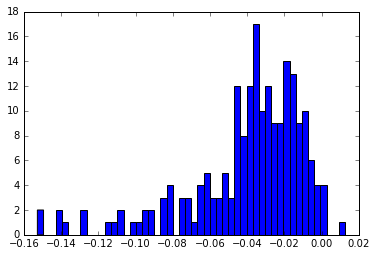

In [139]:
def get_rid0(x,y):
    if y!=0:
        pct = (x-y)/y
    else:
        pct = 0
    return pct
diff = map(lambda x,y: get_rid0(x,y), test['fl_peakflux_goes'],peaks['peakflux_cgs'])
print diff
print np.max(np.array(diff))
plt.hist(diff, bins=50)

### Load lightcurve and events data

In [3]:
def get_relevant_lightcurve_goes(start_time, end_time, lightcurve, a = True):
    lightcurve_search = lightcurve.ix[lightcurve['date']>=start_time]
    lightcurve_search = lightcurve_search.ix[lightcurve_search['date']<=end_time]
    return lightcurve_search

In [ ]:
#first calls to get lightcurves (saved locally)

lightcurve_goes = pd.read_csv('raw_GOES_lightcurves.csv', delimiter = ',', header = 0)
print 'got lightcurve, starting date conversion'
lightcurve_goes['date'] = map(parse_time, lightcurve_goes['date'])



In [6]:
events = pd.read_csv('prepped_GOES.csv', delimiter=',', header=0)
events['event_starttime'] = map(parse_time, events['event_starttime'])
print 'done start times'
events['event_endtime'] = map(parse_time, events['event_endtime'])
print 'done end times'
 events['event_peaktime'] = map(parse_time, events['event_peaktime'])
print 'done peak times'
start_date = datetime.datetime(2011, 3, 1)
events = events.ix[events['event_starttime']>=start_date]

done start times
done end times


In [ ]:
prepped2 = pd.read_csv('prepped_GOES2.csv', delimiter = ',', header = 0)
prepped2['event_starttime'] = map(parse_time, prepped2['event_starttime'])
print 'done start times'
prepped2['event_endtime'] = map(parse_time, prepped2['event_endtime'])
print 'done end times'
prepped2['event_peaktime'] = map(parse_time, prepped2['event_peaktime'])
print 'done peak times'

### Make a train set via visual inspection of 200 events

In [37]:
def response_sequence():
    validResponse = False
    while validResponse==False:
        response = raw_input('1-ideal flare \n2-no flare \n3-meh flare \n4-data dropout \n5-poor event timing \n6-other \nClassify this event:')
        if response=='1':
            evalu = 'ideal flare'
            validResponse = True
        elif response=='2':
            evalu = 'no flare'
            validResponse = True
        elif response=='3':
            evalu = 'meh flare'
            validResponse = True
        elif response=='4':
            evalu = 'data dropout'
            validResponse = True
        elif response=='5':
            evalu = 'poor event timing'
            validResponse = True
        elif response=='6':
            response = raw_input('Add note: ')
            if response != None:
                evalu = response
                response = 6
                validResponse = True
        
        else:
            print 'Oops! Not a valid response. Please try again.'
    return evalu, response

In [89]:
def create_test_set(n, events, lightcurve_goes, delta_t, folder):
    skips_between_events = (events.shape[0])/n
    j = 0
    none_list = [None for k in range(events.shape[0])]
    events.loc[:, 'lightcurve'] = none_list
    events.loc[:, 'verdict'] = none_list  
    for elem in events['event_starttime']:
        if j%skips_between_events==0:
            numprinting = j/skips_between_events
            print '%d / % d' %(numprinting, n)
            print j
            plt.title('Light Curve')
            yLabel = r'Flux [$W/m^2$]'
            delta_t = np.timedelta64(delta_t, 'm')
            start = elem - delta_t
            end = events['event_endtime'].values[j] + delta_t
            lightcurve = get_relevant_lightcurve_goes(start, end, lightcurve_goes)
            lightcurve_save = get_relevant_lightcurve_goes(elem, events['event_endtime'].values[j] , lightcurve_goes)
            if lightcurve.shape[0] != 0:
                #events['lightcurve'].values[i] = list(lightcurve_save['xrsb'])
                minutesX = ((lightcurve['date'] - events['event_starttime'].values[j])*10**(-9))
                minutesX = map(lambda x: x/np.timedelta64(1, 'ns'), minutesX)
                duration = minutesX[-1]-minutesX[0]
                plt.plot(minutesX, lightcurve['xrsb'], color = 'black', lw=2)
                plt.ylabel(r'Flux [$W/m^2$]')
                plt.xlabel('Time [s]')
                
                peakX = (((events['event_peaktime'].values[j]-events['event_starttime'].values[j])*10**(-9))/
                        np.timedelta64(1, 'ns'))
                endX = (((events['event_endtime'].values[j]-events['event_starttime'].values[j])*10**(-9))/
                        np.timedelta64(1, 'ns'))
                
                rect_minus_peak = peakX-60
                rect_plus_peak = peakX+60
                plt.axvspan(rect_minus_peak, rect_plus_peak, color = 'blue', alpha = 0.25)
                rect_minus_end = endX-60
                rect_plus_end = endX+60
                plt.axvspan(rect_minus_end, rect_plus_end, color = 'red', alpha = 0.25)
                plt.axvspan(-60, 60, color='r', alpha=0.25)
                plt.axvline(0, ls='--', color='r')
                plt.axvline(endX, ls='--', color='r')
                plt.axvline(peakX, ls=':', color='b')
                plt.show()
                text, verdict = response_sequence()
                title = 'Classified as: ' + text
                plt.title(title)
                plt.plot(minutesX, lightcurve['xrsb'], color = 'black')
                plt.ylabel(r'Flux [$W/m^2$]')
                plt.xlabel('Time [s]')
                plt.axvline(0, ls='--', color='r')
                rect_minus_peak = peakX-60
                rect_plus_peak = peakX+60
                plt.axvspan(rect_minus_peak, rect_plus_peak, color = 'blue', alpha = 0.25)
                rect_minus_end = endX-60
                rect_plus_end = endX+60
                plt.axvspan(rect_minus_end, rect_plus_end, color = 'red', alpha = 0.25)
                plt.axvspan(-60, 60, color='r', alpha=0.25)
                plt.axvline(peakX, ls=':', color='b')
                plt.axvline(endX, ls='--', color='r')
                fNameSave = folder + '/' + str(j)
                plt.savefig(fNameSave, bbox_inches = 'tight', pad_inches = 0.25)
                plt.close()
                events['verdict'].values[j] = verdict  
            else:
                verdict = 5 #'no data'
                events['verdict'].values[j] = verdict  
                
        j+=1
    
    events_cut = events[::skips_between_events]
    events_cut.to_csv('sklearn_goes1.csv', index=False, columns=['SOL_standard', 'event_starttime', 'event_endtime', 
                                                                 'lightcurve', 'verdict'], 
                      date_format = '%Y-%m-%dT%X')
    return events


In [128]:
def create_test_set(n, events, lightcurve_goes, delta_t, folder):
    skips_between_events = (events.shape[0])/n
    j = 0
    numgraph = 0
    none_list = [None for k in range(events.shape[0])]
    events.loc[:, 'lightcurve'] = none_list
    events.loc[:, 'verdict'] = none_list  
    for elem in events['event_starttime']:
        if j%skips_between_events==0:
            numprinting = j/skips_between_events
            print '%d / % d' %(numprinting, n)
            print j
            plt.title('Light Curve')
            yLabel = r'Flux [$W/m^2$]'
            delta_t = np.timedelta64(delta_t, 'm')
            start = elem - delta_t
            end = events['event_endtime'].values[j] + delta_t
            lightcurve = get_relevant_lightcurve_goes(start, end, lightcurve_goes)
            lightcurve_save = get_relevant_lightcurve_goes(elem, events['event_endtime'].values[j] , lightcurve_goes)
            if lightcurve.shape[0] != 0:
                #events['lightcurve'].values[i] = list(lightcurve_save['xrsb'])
                minutesX = (lightcurve['date'] - events['event_starttime'].values[j])
                minutesX = map(lambda x: x/np.timedelta64(1, 'ns'), minutesX)
                duration = minutesX[-1]-minutesX[0]
                plt.plot(minutesX, lightcurve['xrsb'], color = 'black', lw=2)
                plt.ylabel(r'Flux [$W/m^2$]')
                plt.xlabel('Time [s]')
                
                peakX2 = (((events['event_peaktime'].values[j]-events['event_starttime'].values[j]))/
                         np.timedelta64(1, 'ns'))
#                 print peaks['peaktime'].values[j]
                peakX = ((peaks['peaktime'].values[numgraph]-events['event_starttime'].values[j])/
                        np.timedelta64(1, 'ns'))
                endX = ((events['event_endtime'].values[j]-events['event_starttime'].values[j])/
                        np.timedelta64(1, 'ns'))
                
#                 rect_minus_peak = peakX-60*10**(-9)
#                 rect_plus_peak = peakX+60*10**(-9)
#                 plt.axvspan(rect_minus_peak, rect_plus_peak, color = 'blue', alpha = 0.25)
                rect_minus_end = endX-60*10**(-9)
                rect_plus_end = endX+60*10**(-9)
                plt.axvspan(rect_minus_end, rect_plus_end, color = 'red', alpha = 0.25)
                plt.axvspan(-60, 60, color='r', alpha=0.25)
                plt.axvline(0, ls='--', color='r')
                plt.axvline(endX, ls='--', color='r')
                plt.axvline(peakX, ls=':', color='b', lw =1.5)
                plt.axvline(peakX2, ls='-.', color='green', lw=1.5)
                plt.show()
#                 text, verdict = response_sequence()
#                 title = 'Classified as: ' + text
#                 plt.title(title)
#                 plt.plot(minutesX, lightcurve['xrsb'], color = 'black')
#                 plt.ylabel(r'Flux [$W/m^2$]')
#                 plt.xlabel('Time [s]')
#                 plt.axvline(0, ls='--', color='r')
#                 rect_minus_peak = peakX-60
#                 rect_plus_peak = peakX+60
#                 plt.axvspan(rect_minus_peak, rect_plus_peak, color = 'blue', alpha = 0.25)
#                 rect_minus_end = endX-60
#                 rect_plus_end = endX+60
#                 plt.axvspan(rect_minus_end, rect_plus_end, color = 'red', alpha = 0.25)
#                 plt.axvspan(-60, 60, color='r', alpha=0.25)
#                 plt.axvline(peakX, ls=':', color='b')
#                 plt.axvline(endX, ls='--', color='r')
#                 fNameSave = folder + '/' + str(j)
                #plt.savefig(fNameSave, bbox_inches = 'tight', pad_inches = 0.25)
                plt.close()
                numgraph+=1
#                 events['verdict'].values[j] = verdict  
            else:
                verdict = 5 #'no data'
#                 events['verdict'].values[j] = verdict  
                
        j+=1
        
    
    events_cut = events[::skips_between_events]
#     events_cut.to_csv('sklearn_goes1.csv', index=False, columns=['SOL_standard', 'event_starttime', 'event_endtime', 
#                                                                  'lightcurve', 'verdict'], 
#                       date_format = '%Y-%m-%dT%X')
    return events

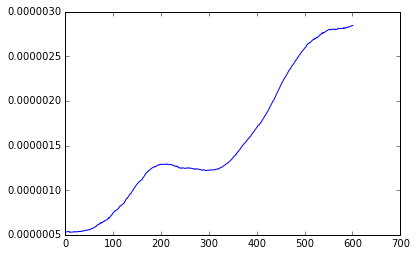

In [131]:
check = pd.read_csv('sklearn_goes_train_lc/checker.csv', delimiter=',', header = 0)
plt.plot(check['xrsb'])

0 /  200
0


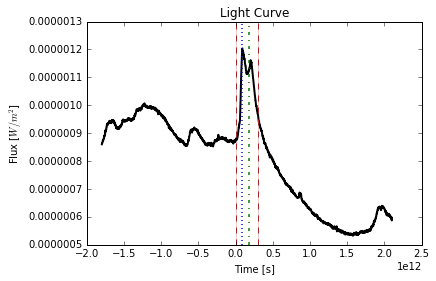

1 /  200
36


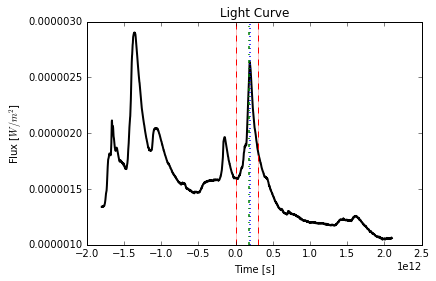

2 /  200
72


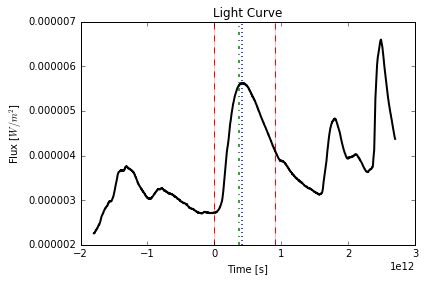

3 /  200
108


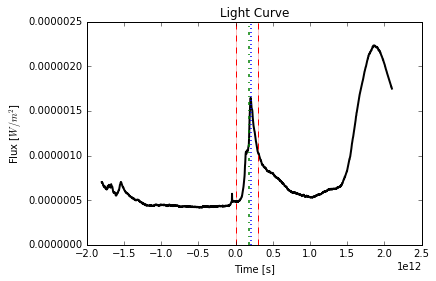

4 /  200
144


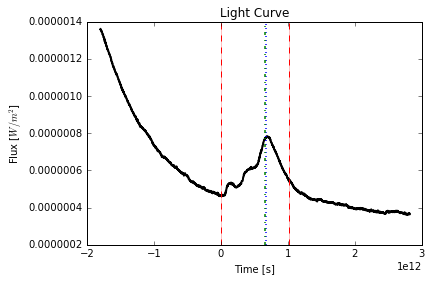

5 /  200
180


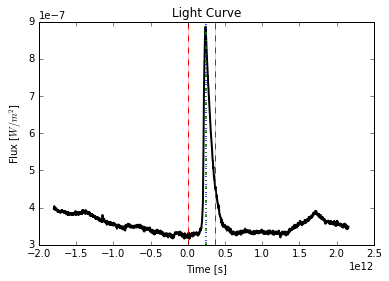

6 /  200
216


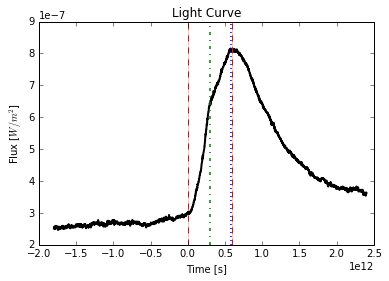

7 /  200
252


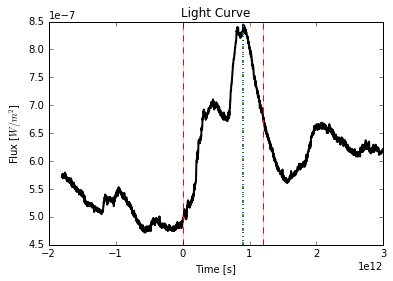

8 /  200
288


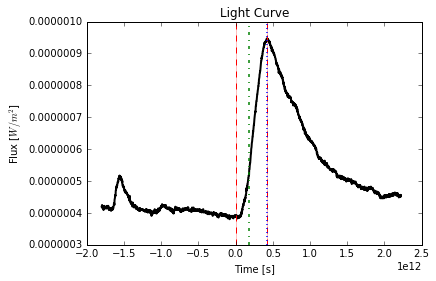

9 /  200
324


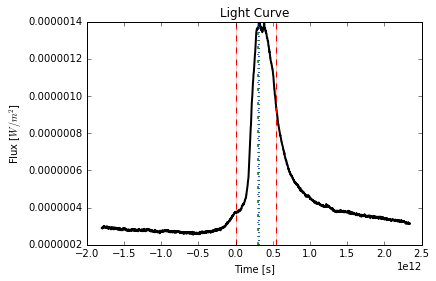

10 /  200
360


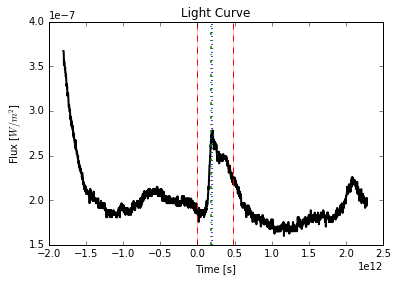

11 /  200
396


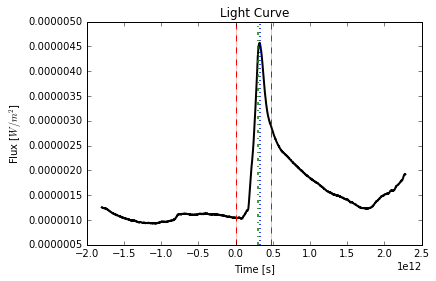

12 /  200
432


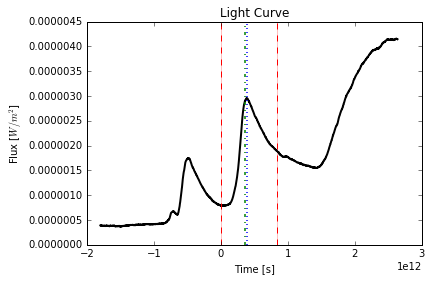

13 /  200
468


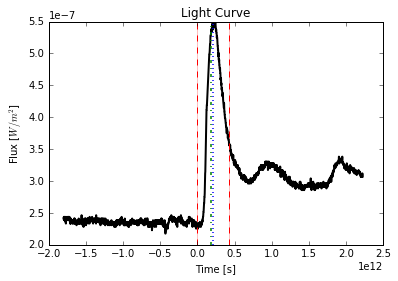

14 /  200
504


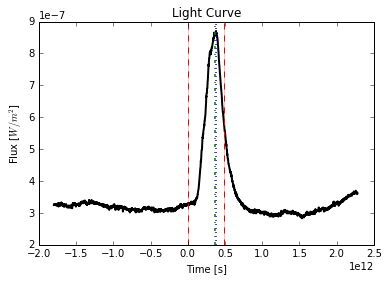

15 /  200
540


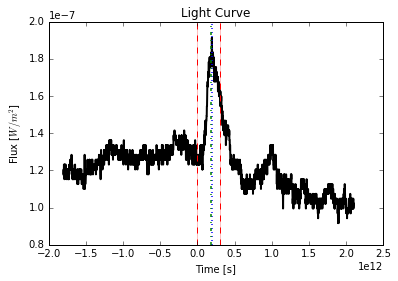

16 /  200
576


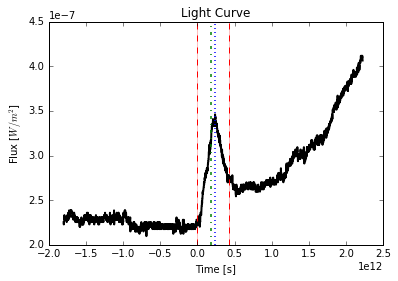

17 /  200
612


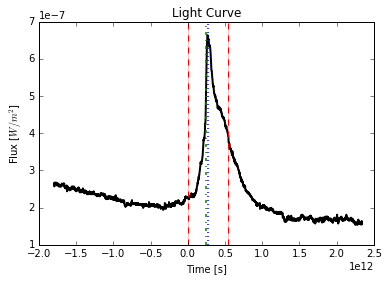

18 /  200
648


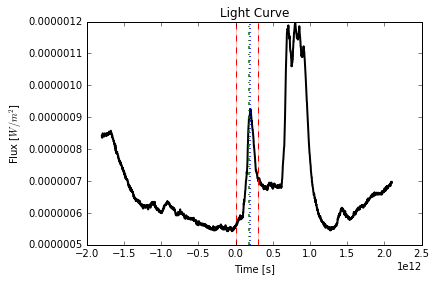

19 /  200
684


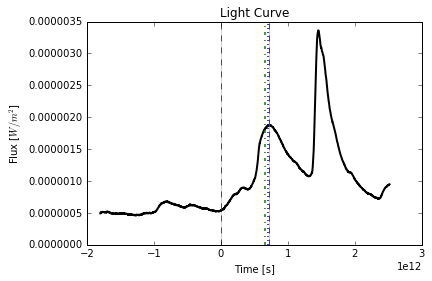

20 /  200
720


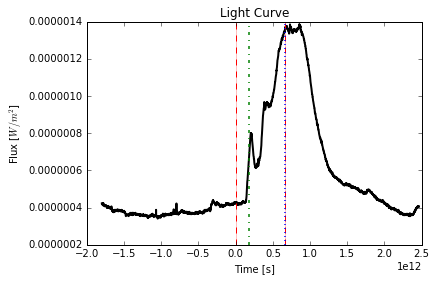

21 /  200
756


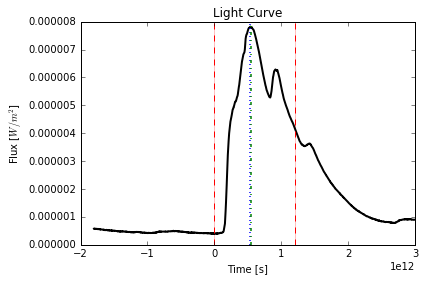

22 /  200
792


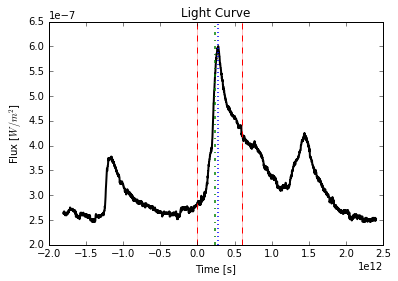

23 /  200
828


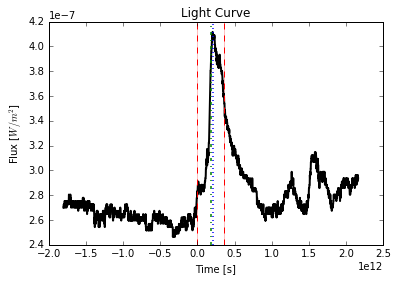

24 /  200
864


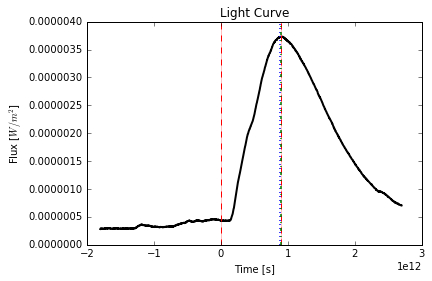

25 /  200
900


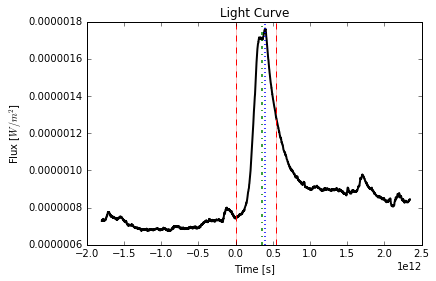

26 /  200
936


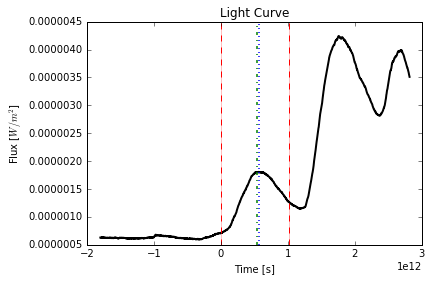

27 /  200
972


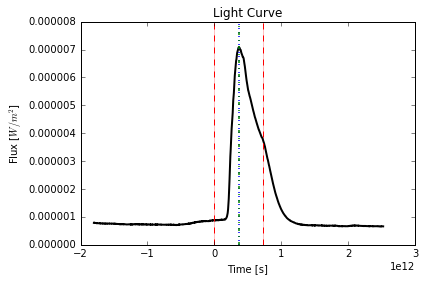

28 /  200
1008


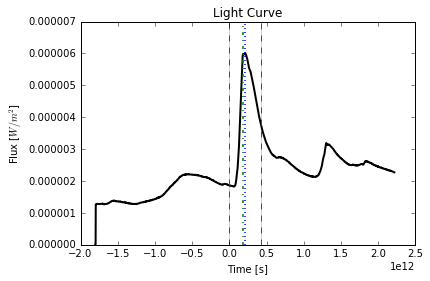

29 /  200
1044


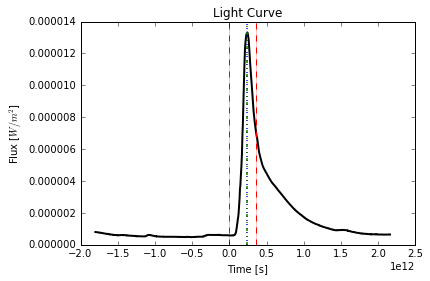

30 /  200
1080


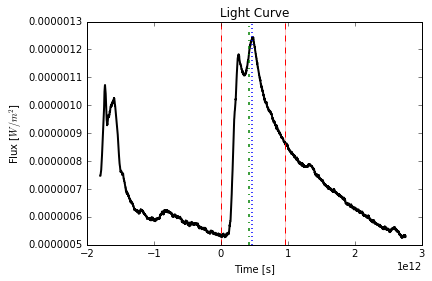

31 /  200
1116


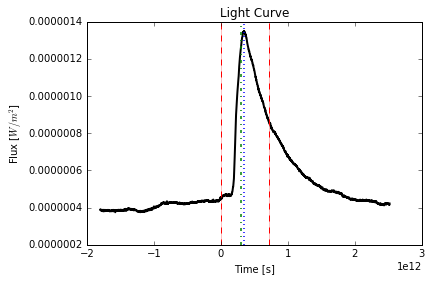

32 /  200
1152


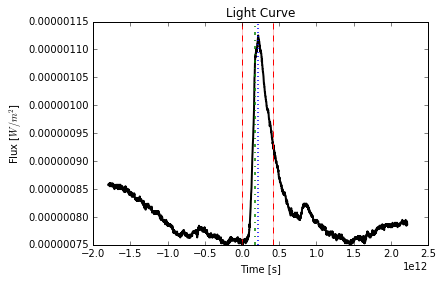

33 /  200
1188


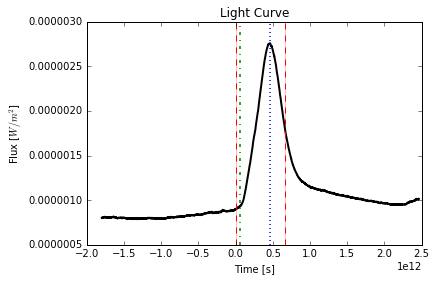

34 /  200
1224


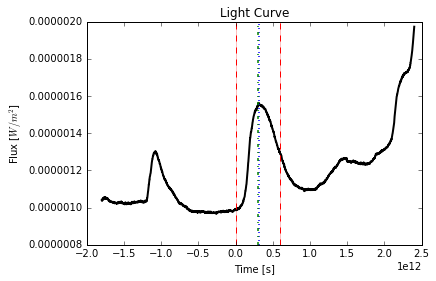

35 /  200
1260


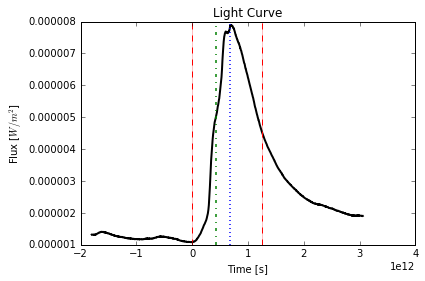

36 /  200
1296


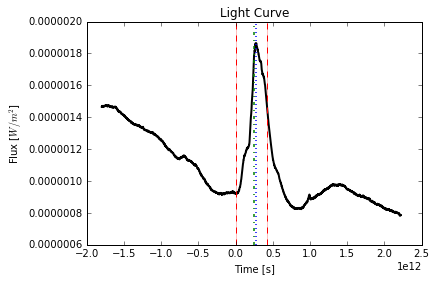

37 /  200
1332


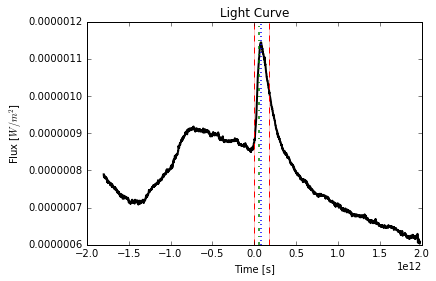

38 /  200
1368


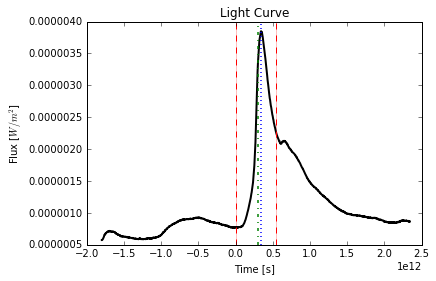

39 /  200
1404


KeyboardInterrupt: 

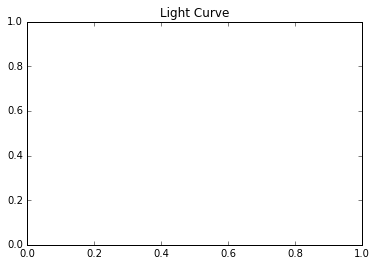

In [132]:
results = create_test_set(200, prepped2, lightcurve_goes, 30, 'tt_GOES1')

# Save lightcurves of interest in separate files by SOL_standard

In [48]:
def add_lightcurves_to_test_set(n, events, lightcurve_goes, folder):
    skips_between_events = (events.shape[0])/n
    j = 0
#     none_list = [None for k in range(events.shape[0])]
#     events.loc[:, 'lightcurve'] = none_list
#     events.loc[:, 'verdict'] = none_list  
    for elem in events['event_starttime']:
        if j%skips_between_events==0:
            numprinting = j/skips_between_events
            print '%d / % d' %(numprinting, n)
            lightcurve = get_relevant_lightcurve_goes(elem, events['event_endtime'].values[j], lightcurve_goes)

            if lightcurve.shape[0] != 0:
                fname = folder + '/' + str(events['SOL_standard'].values[j])+'.csv'
                lightcurve.to_csv(fname, index=False, columns = ['date', 'xrsb'], date_format = '%Y-%m-%dT%X')
#                 xrsb = lightcurve['xrsb']
#                 events['lightcurve'].values[j] = xrsb
                
        j+=1
    
#     events_cut = events[::skips_between_events]
#     events_cut.to_csv('sklearn_goes1_lightcurves.csv', index=False, columns=['SOL_standard','lightcurve'])
#     return events

In [5]:
def add_lightcurves_for_all(events, lightcurve_goes, folder):
    len_events = events.shape[0]
    j = 0
    for elem in events['event_starttime']:
        print '%d / % d' %(j, len_events)
        lightcurve = get_relevant_lightcurve_goes(elem, events['event_endtime'].values[j], lightcurve_goes)

        if lightcurve.shape[0] != 0:
            fname = folder + '/' + str(events['SOL_standard'].values[j])+'.csv'
            lightcurve.to_csv(fname, index=False)
                
        j+=1


In [ ]:
add_lightcurves_for_all(prepped2, lightcurve_goes, 'sklearn_goes_all_lc')

0 /  7311
1 /  7311
2 /  7311
3 /  7311
4 /  7311
5 /  7311
6 /  7311
7 /  7311
8 /  7311
9 /  7311
10 /  7311
11 /  7311
12 /  7311
13 /  7311
14 /  7311
15 /  7311
16 /  7311
17 /  7311
18 /  7311
19 /  7311
20 /  7311
21 /  7311
22 /  7311
23 /  7311
24 /  7311
25 /  7311
26 /  7311
27 /  7311
28 /  7311
29 /  7311
30 /  7311
31 /  7311
32 /  7311


In [61]:
add_lightcurves_to_test_set(200, prepped2, lightcurve_goes, 'sklearn_goes_train_lc')

0 /  200
1 /  200
2 /  200
3 /  200
4 /  200
5 /  200
6 /  200
7 /  200
8 /  200
9 /  200
10 /  200
11 /  200
12 /  200
13 /  200
14 /  200
15 /  200
16 /  200
17 /  200
18 /  200
19 /  200
20 /  200
21 /  200
22 /  200
23 /  200
24 /  200
25 /  200
26 /  200
27 /  200
28 /  200
29 /  200
30 /  200
31 /  200
32 /  200
33 /  200
34 /  200
35 /  200
36 /  200
37 /  200
38 /  200
39 /  200
40 /  200
41 /  200
42 /  200
43 /  200
44 /  200
45 /  200
46 /  200
47 /  200
48 /  200
49 /  200
50 /  200
51 /  200
52 /  200
53 /  200
54 /  200
55 /  200
56 /  200
57 /  200
58 /  200
59 /  200
60 /  200
61 /  200
62 /  200
63 /  200
64 /  200
65 /  200
66 /  200
67 /  200
68 /  200
69 /  200
70 /  200
71 /  200
72 /  200
73 /  200
74 /  200
75 /  200
76 /  200
77 /  200
78 /  200
79 /  200
80 /  200
81 /  200
82 /  200
83 /  200
84 /  200
85 /  200
86 /  200
87 /  200
88 /  200
89 /  200
90 /  200
91 /  200
92 /  200
93 /  200
94 /  200
95 /  200
96 /  200
97 /  200
98 /  200
99 /  200
100 /  200

# Make estimator with sklearn

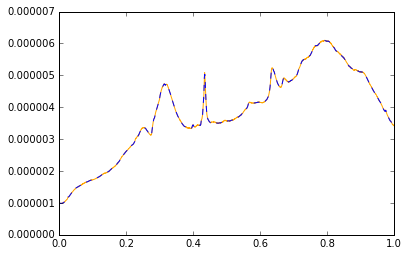

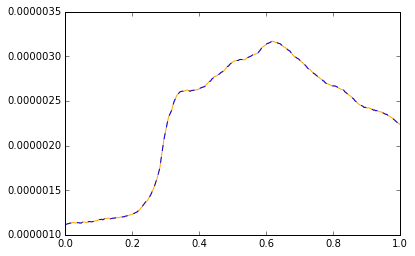

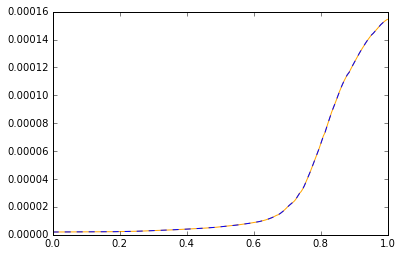

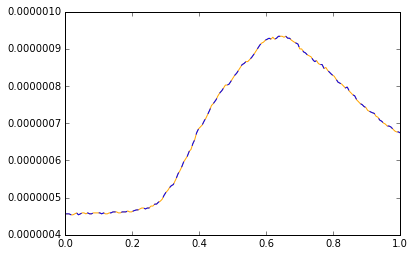

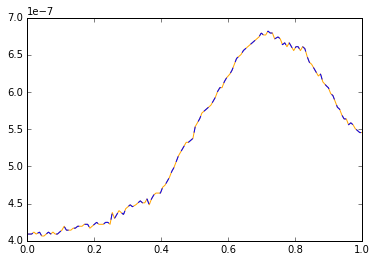

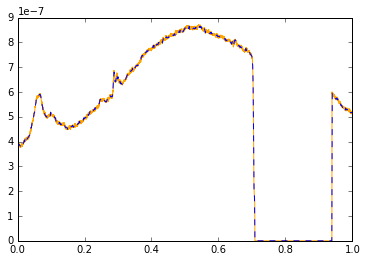

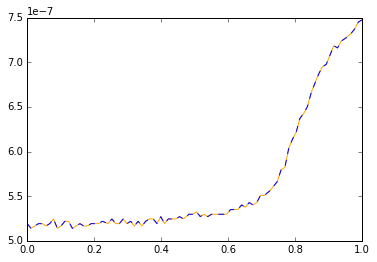

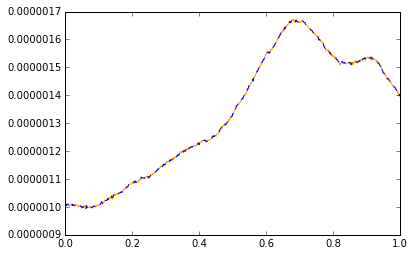

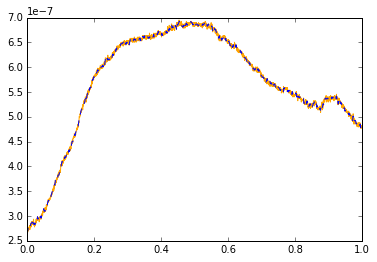

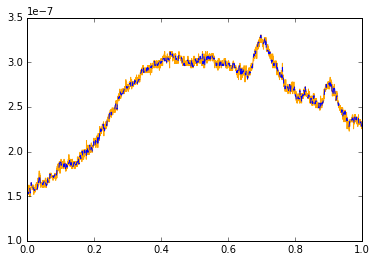

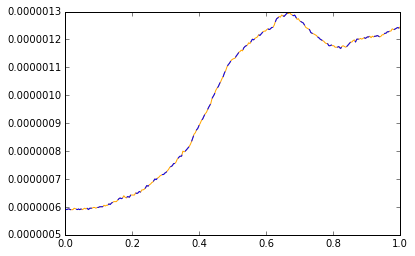

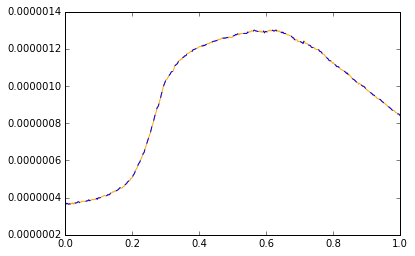

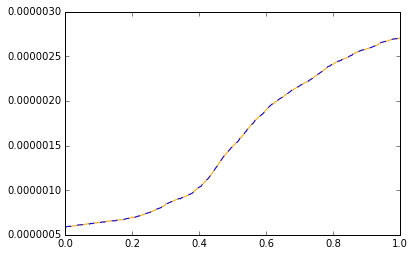

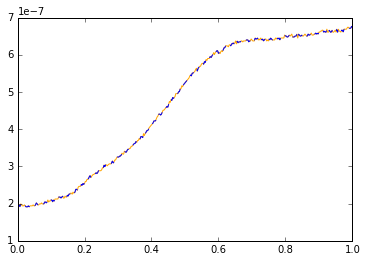

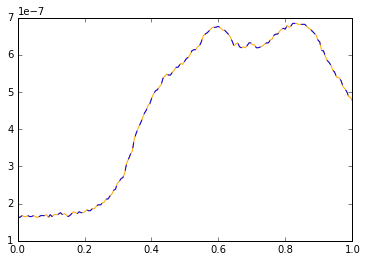

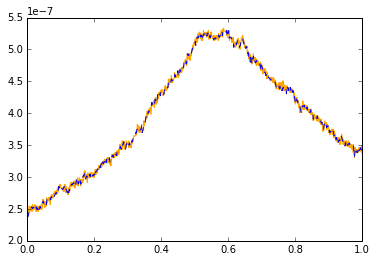

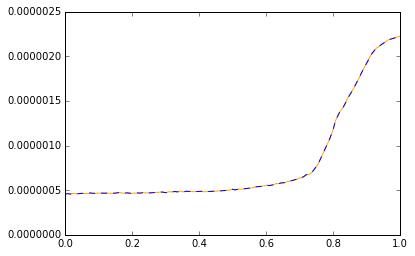

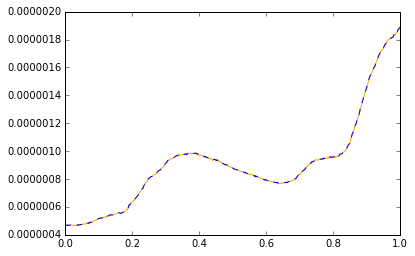

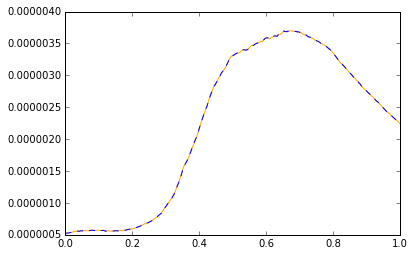

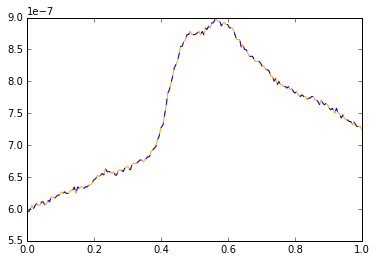

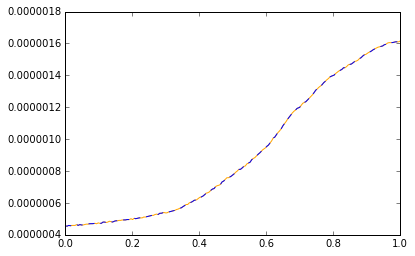

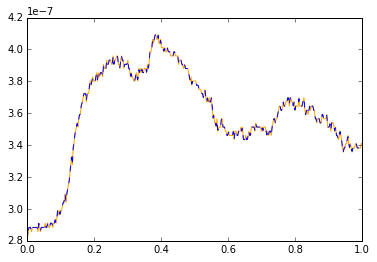

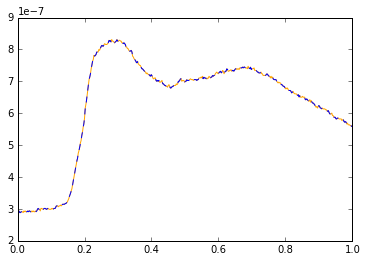

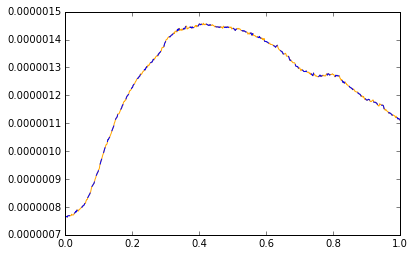

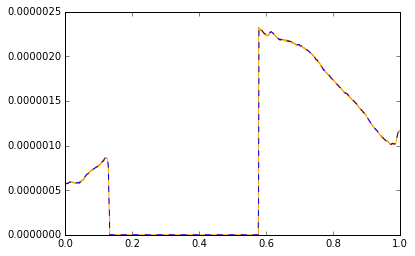

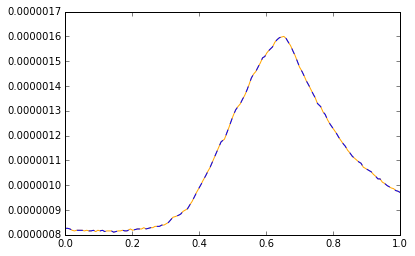

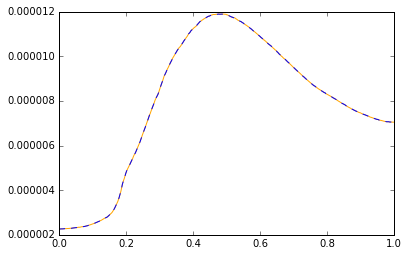

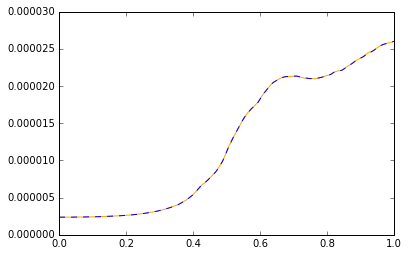

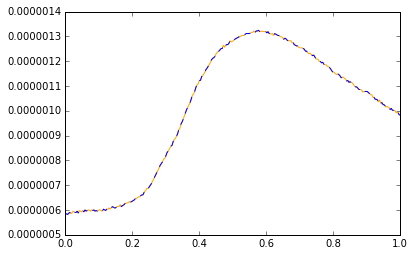

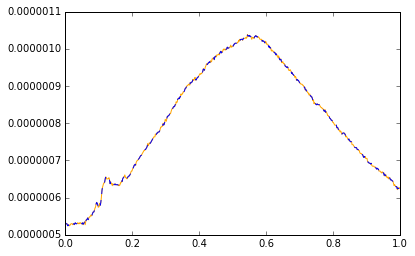

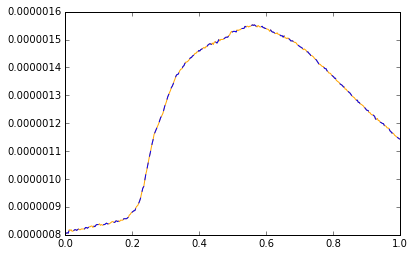

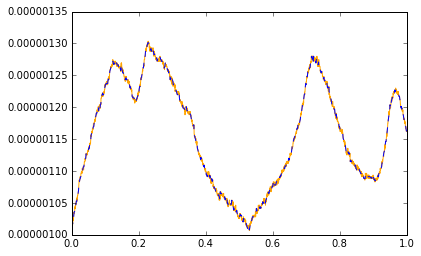

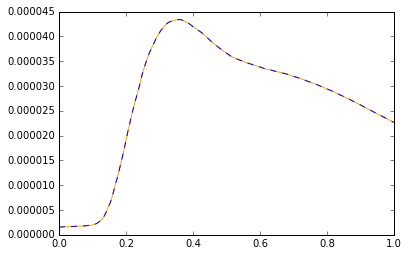

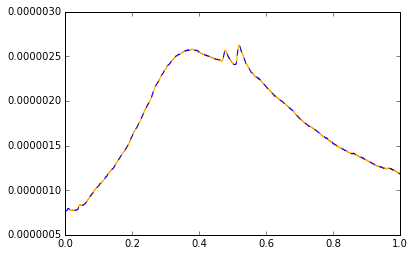

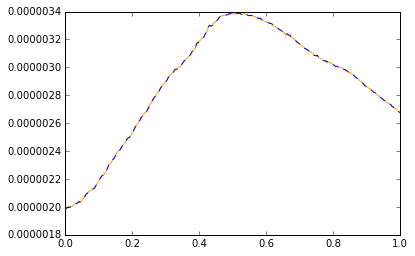

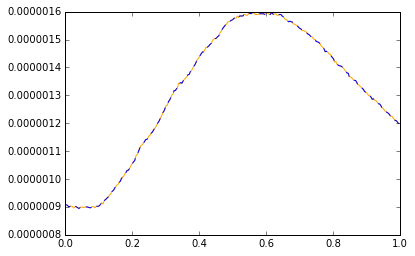

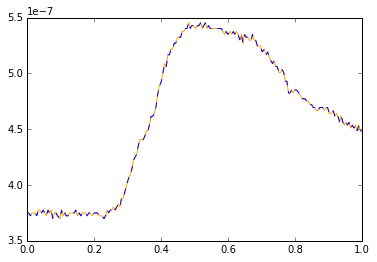

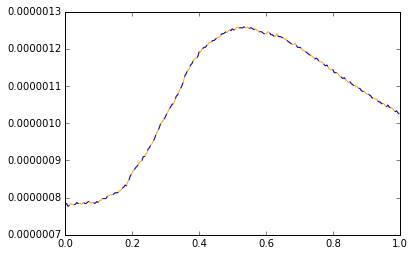

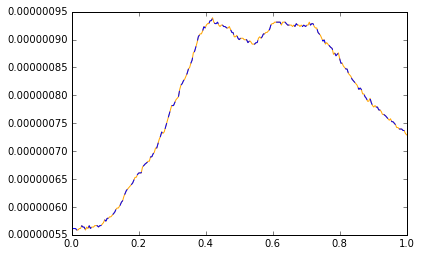

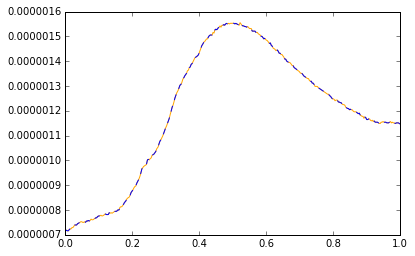

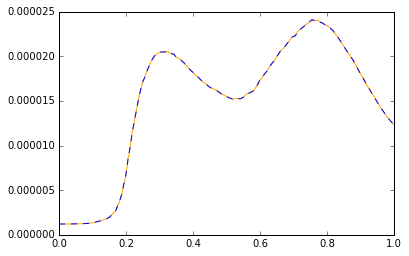

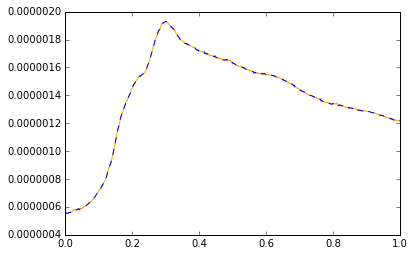

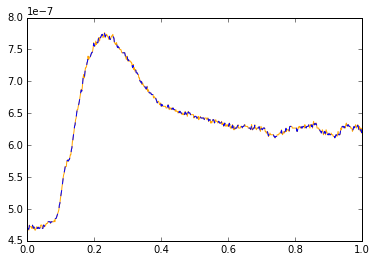

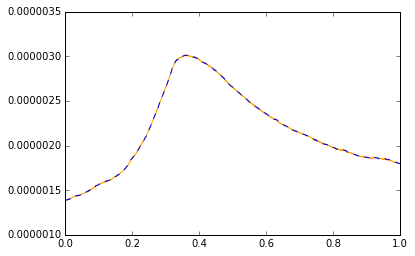

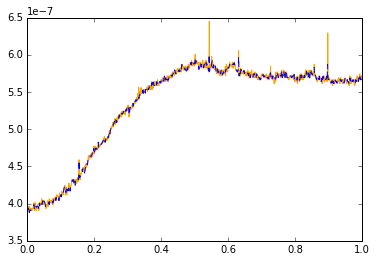

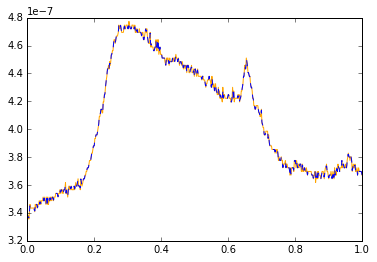

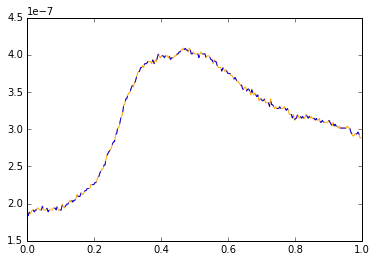

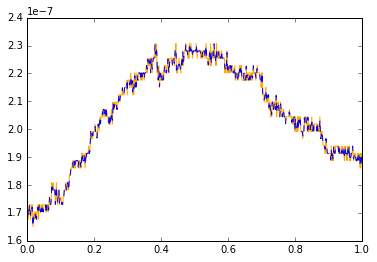

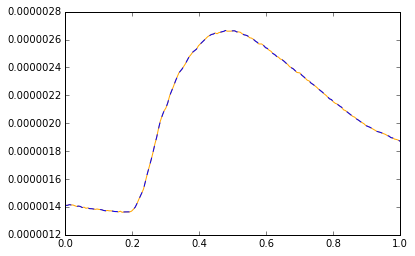

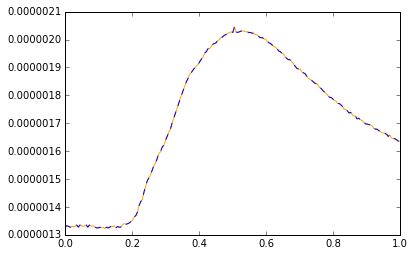

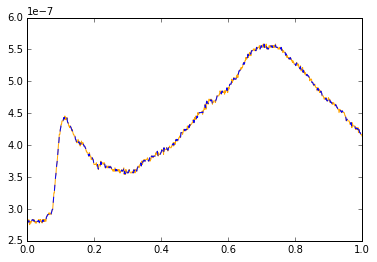

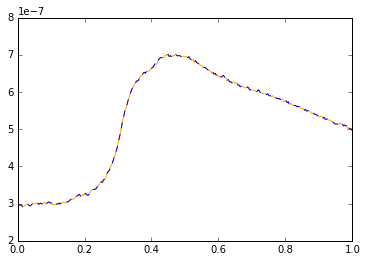

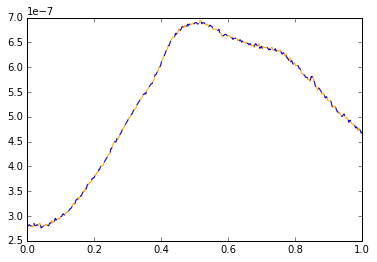

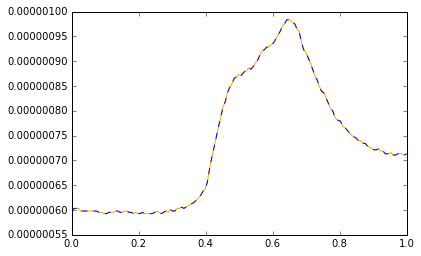

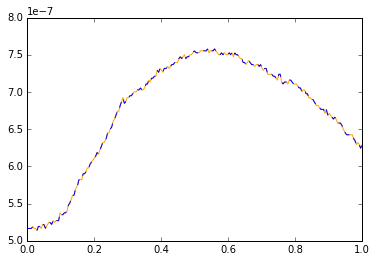

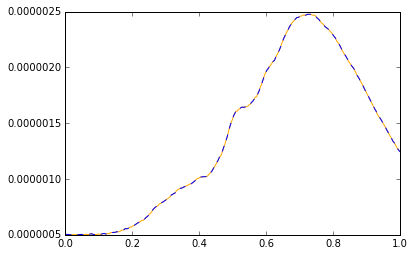

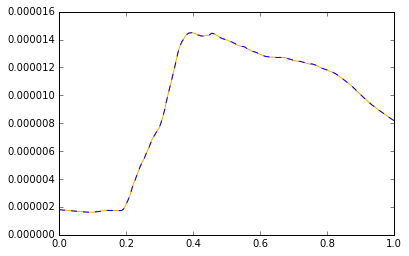

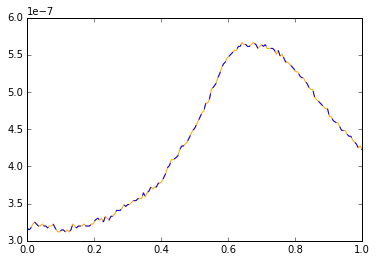

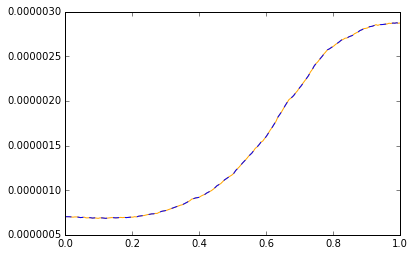

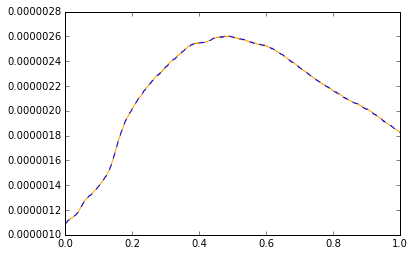

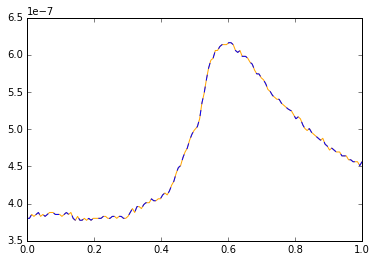

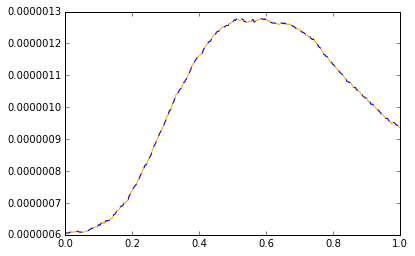

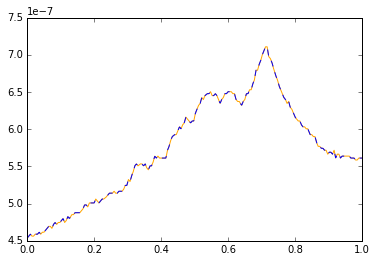

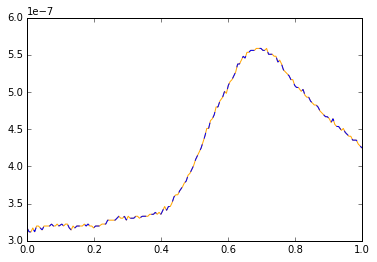

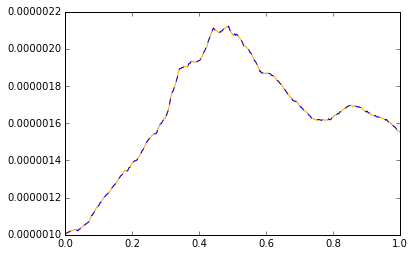

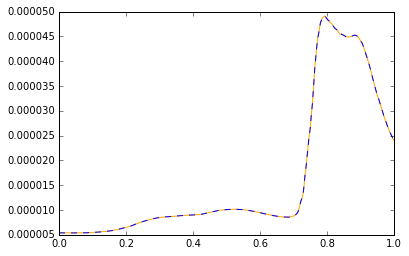

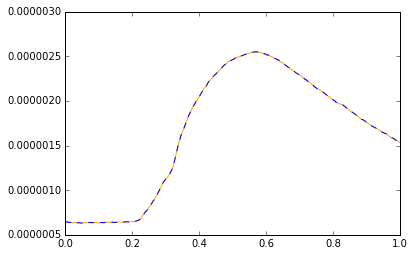

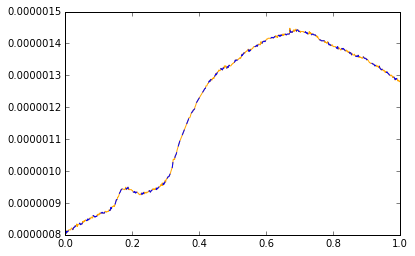

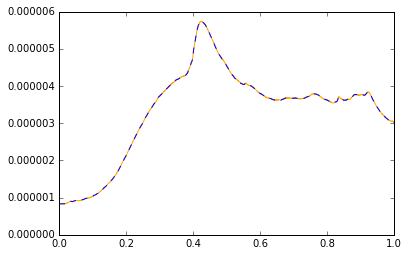

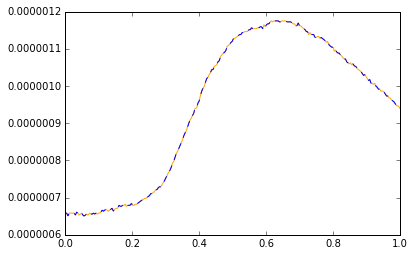

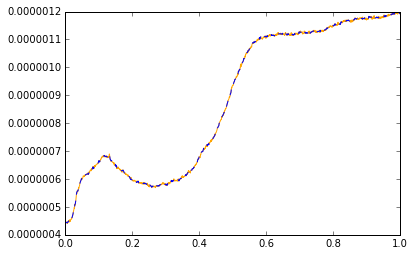

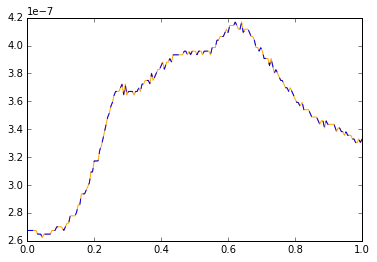

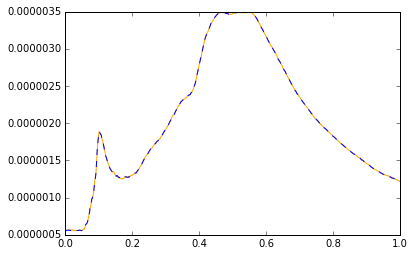

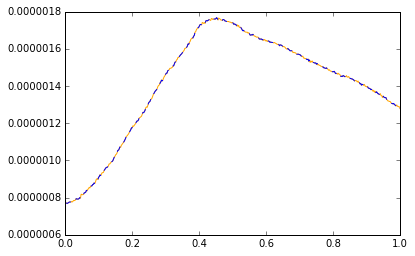

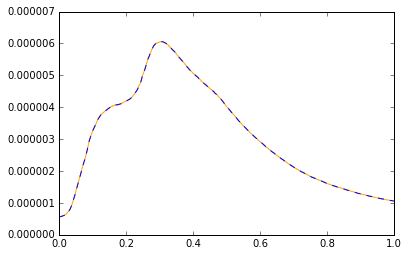

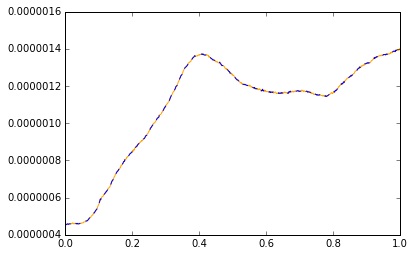

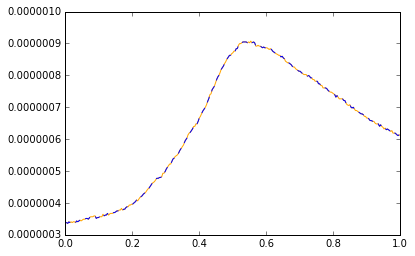

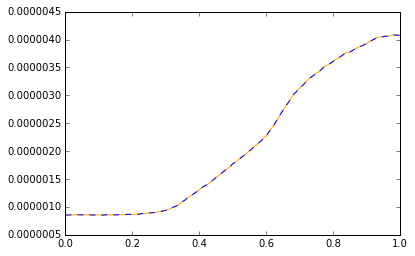

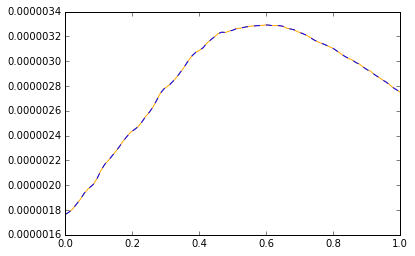

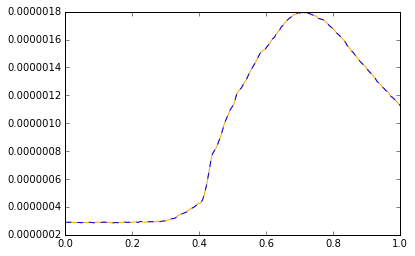

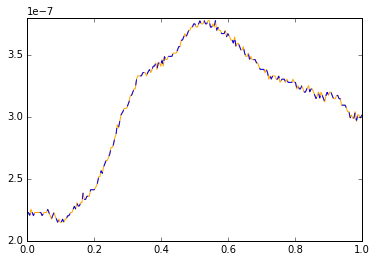

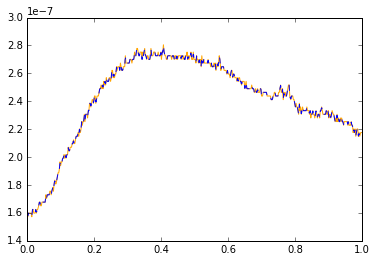

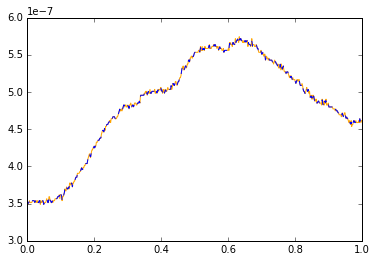

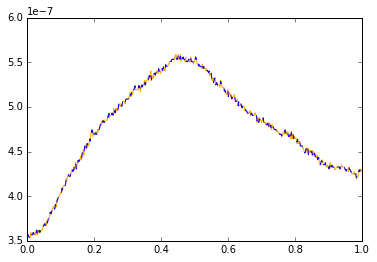

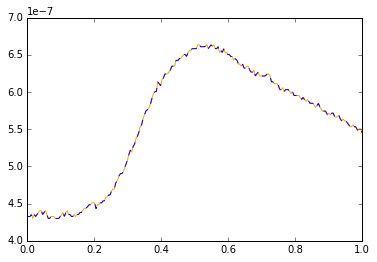

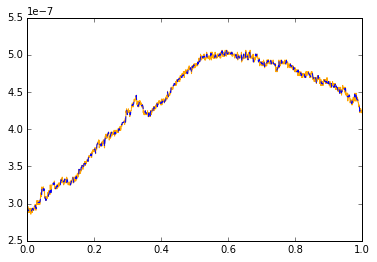

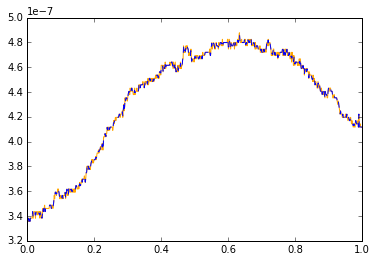

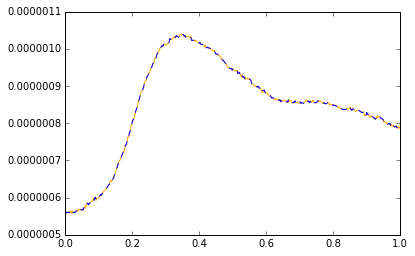

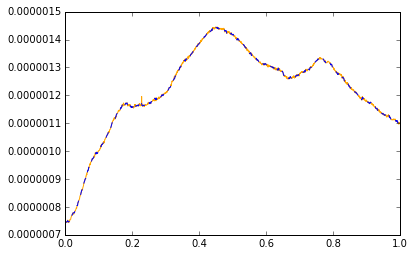

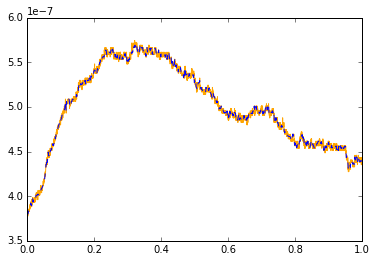

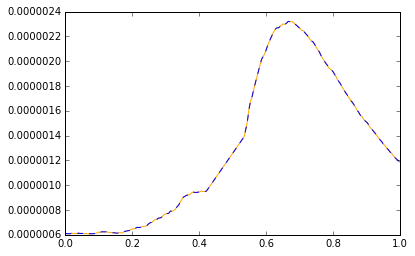

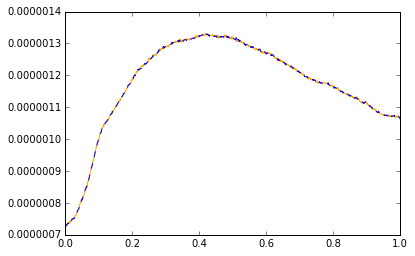

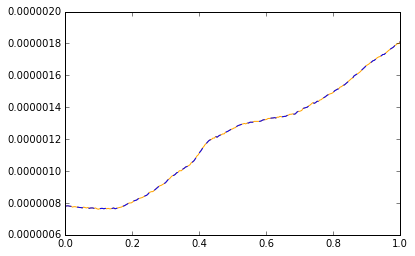

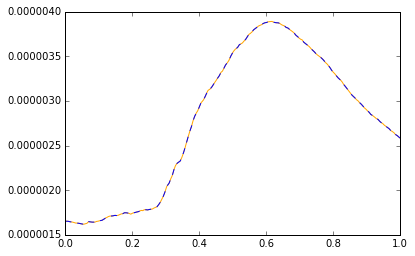

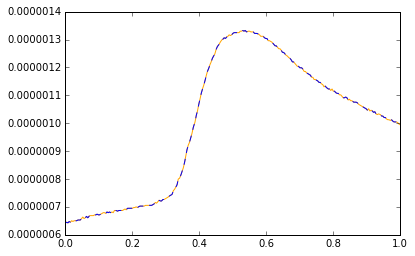

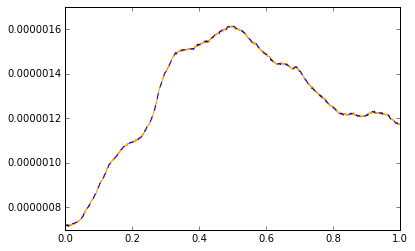

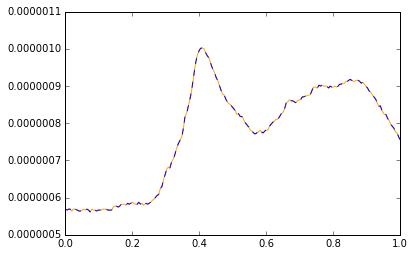

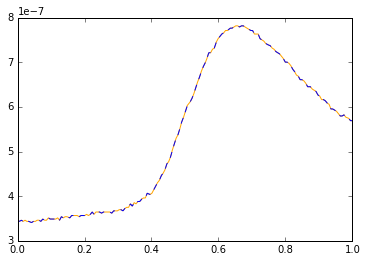

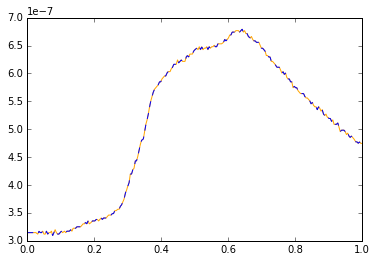

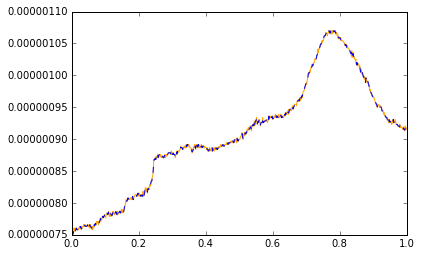

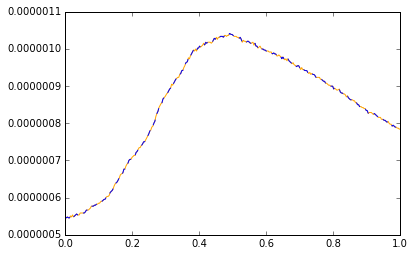

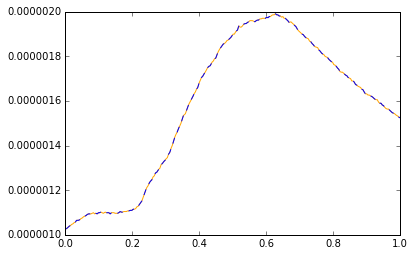

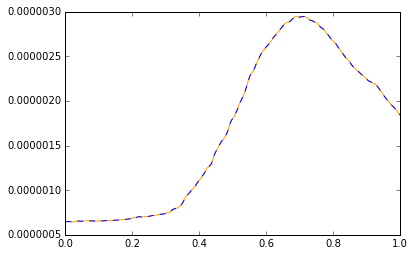

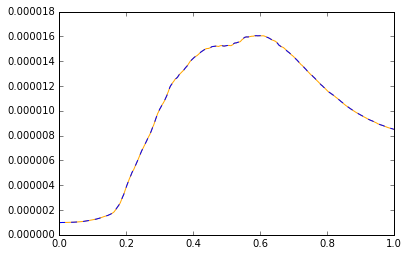

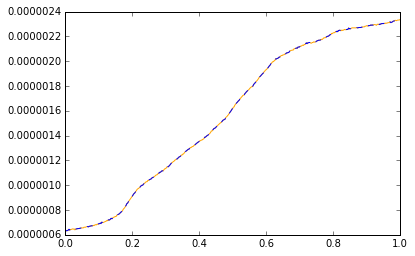

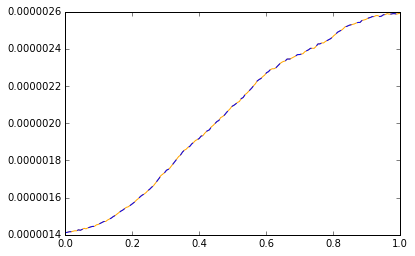

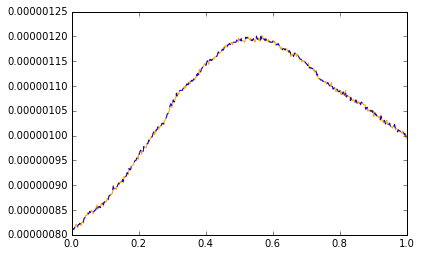

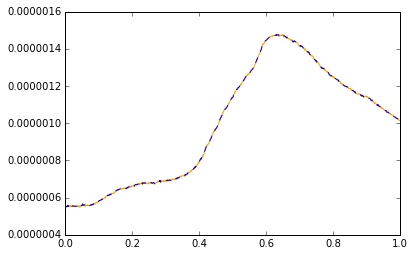

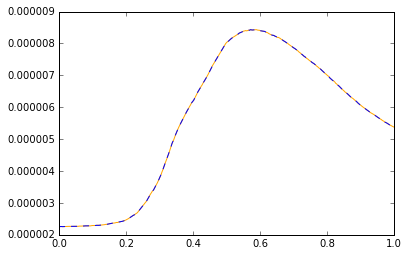

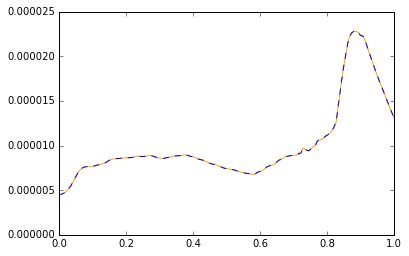

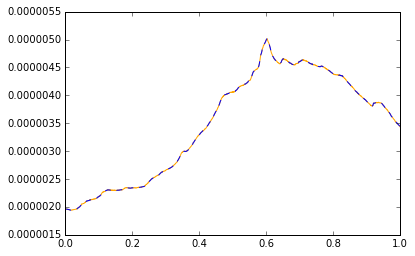

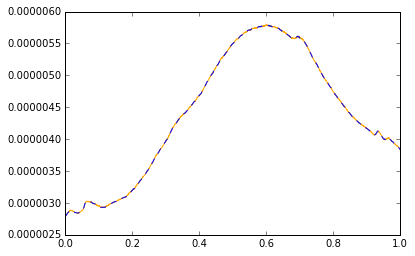

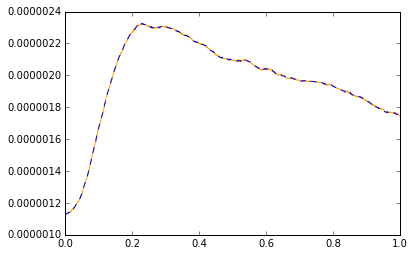

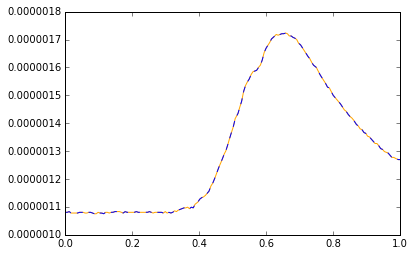

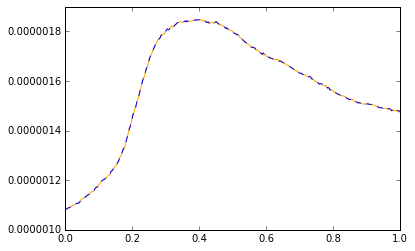

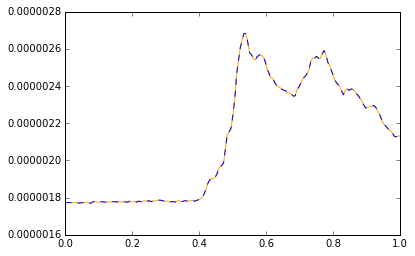

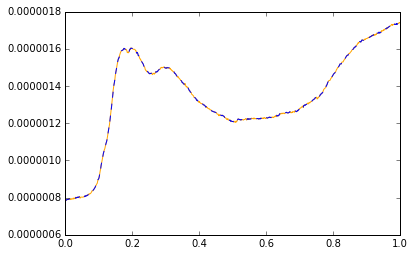

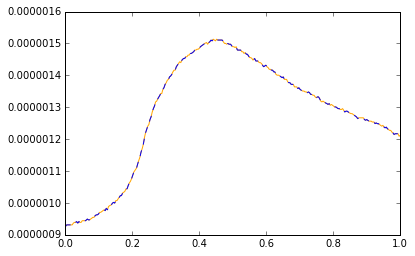

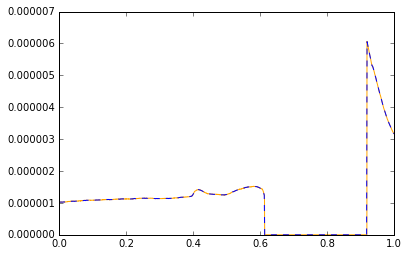

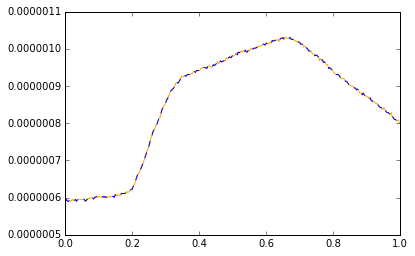

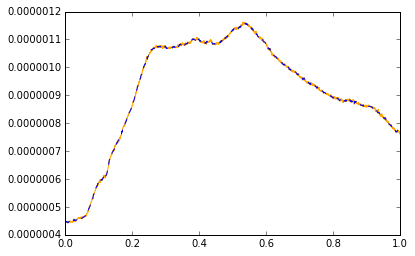

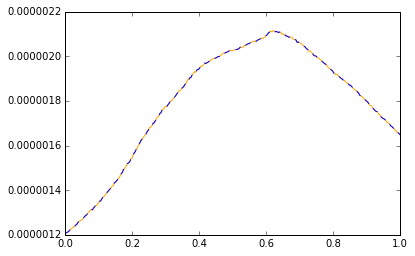

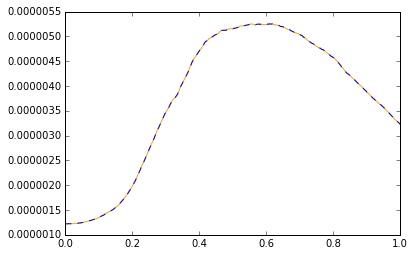

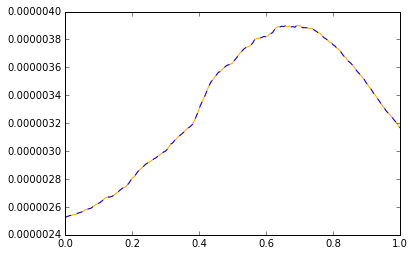

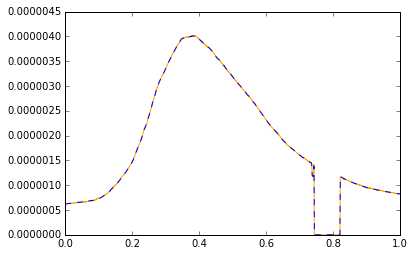

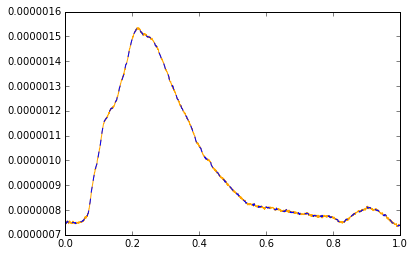

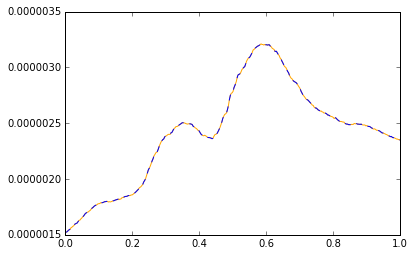

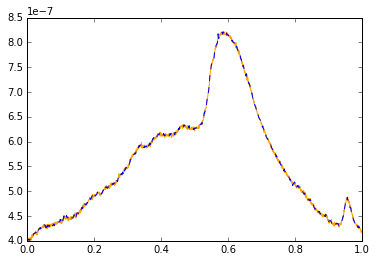

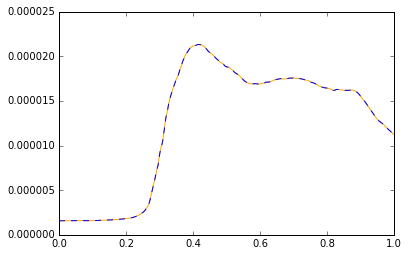

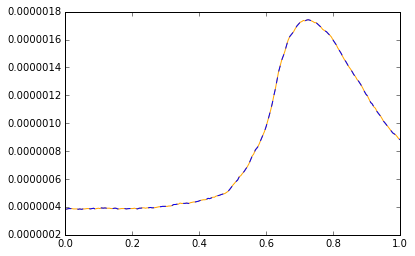

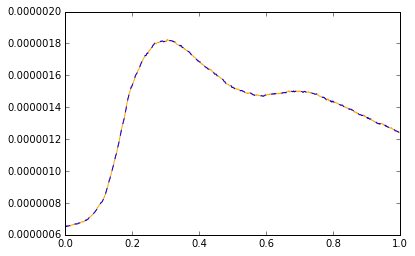

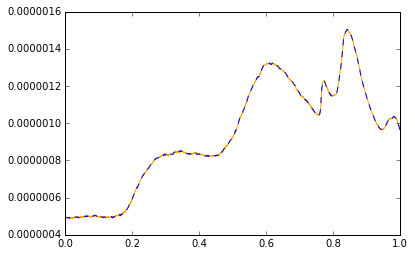

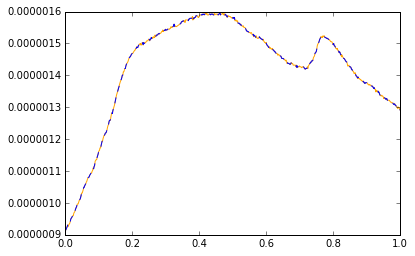

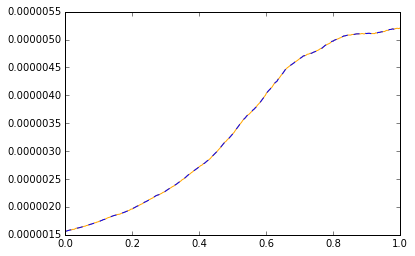

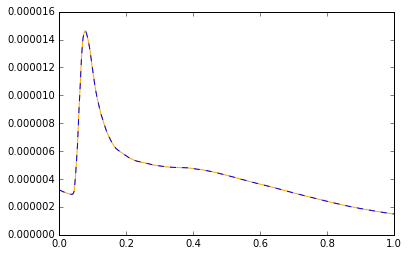

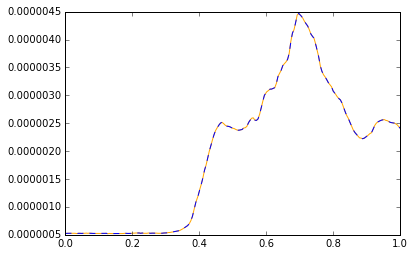

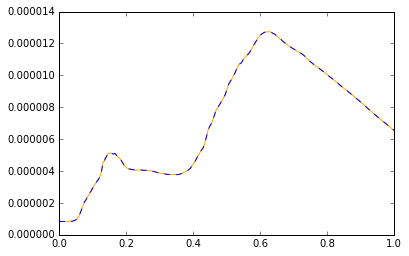

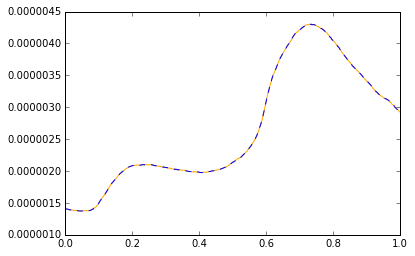

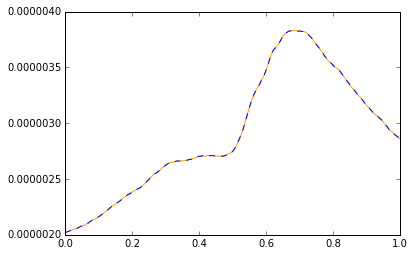

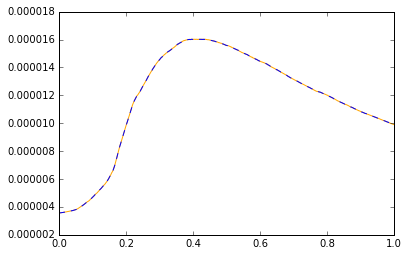

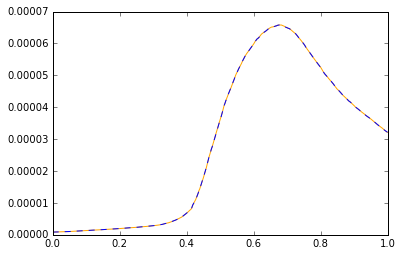

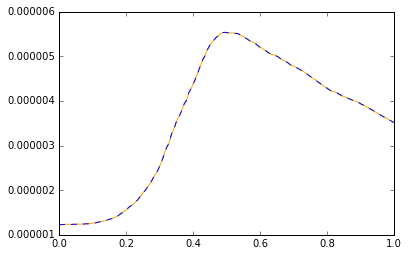

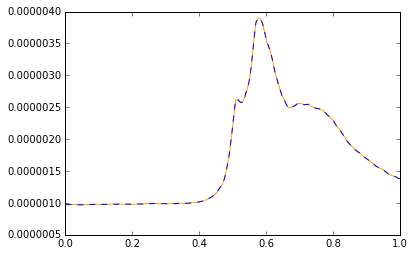

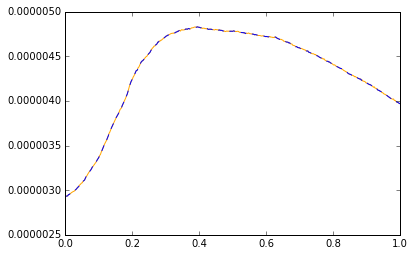

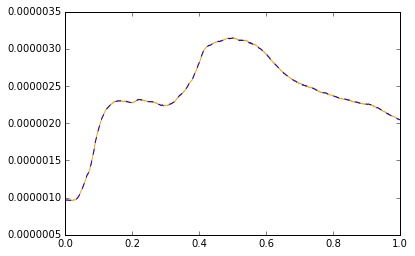

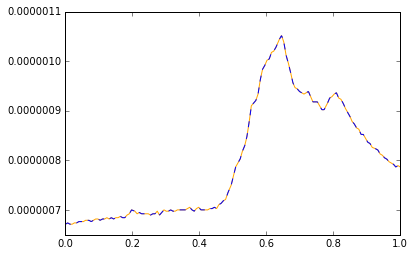

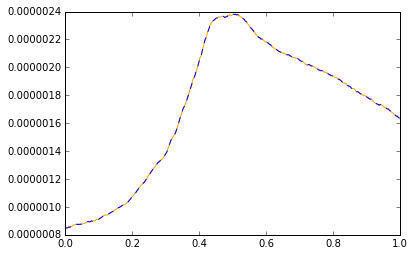

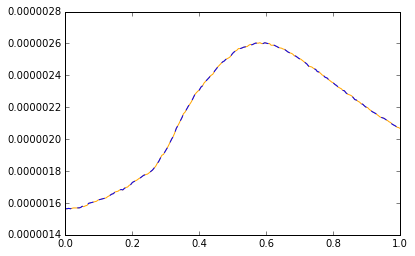

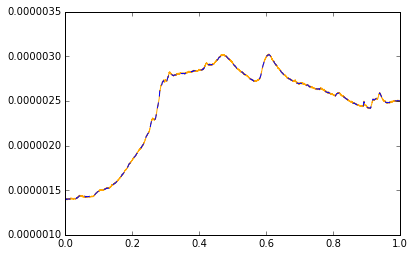

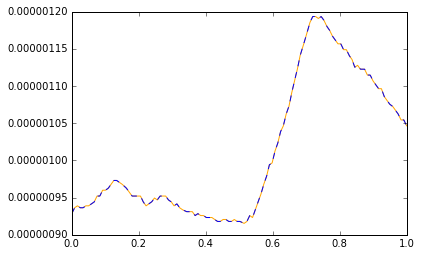

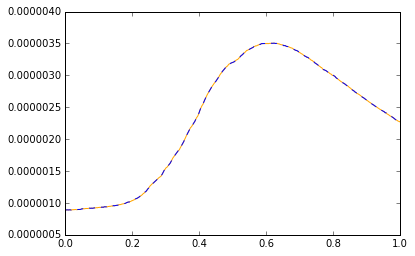

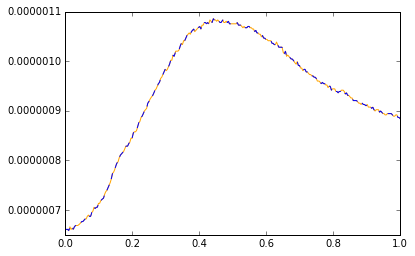

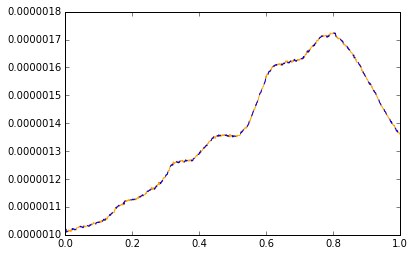

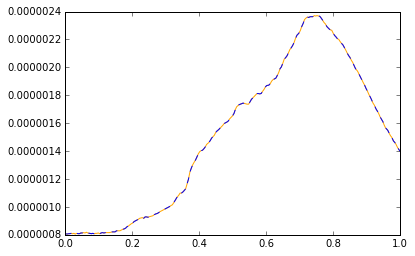

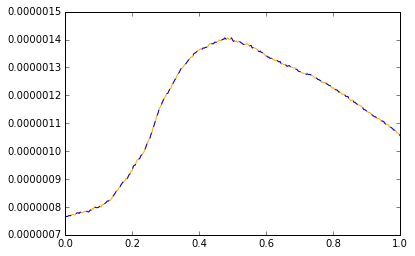

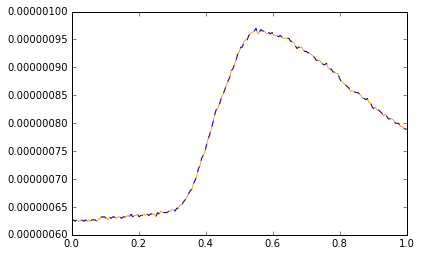

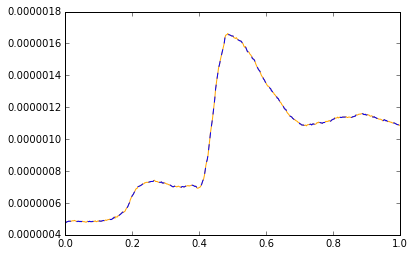

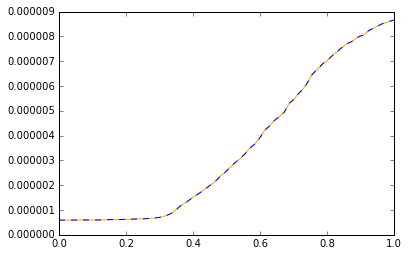

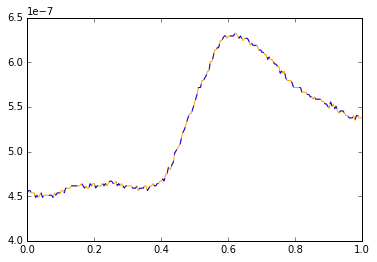

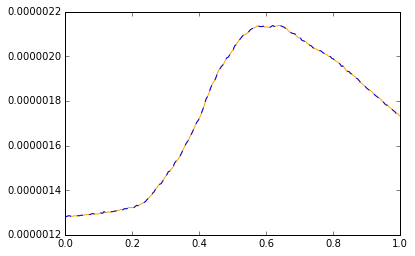

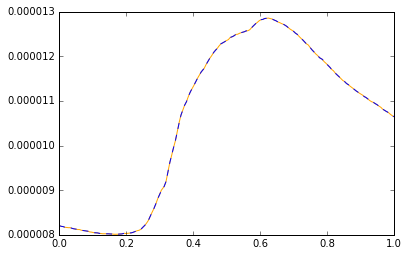

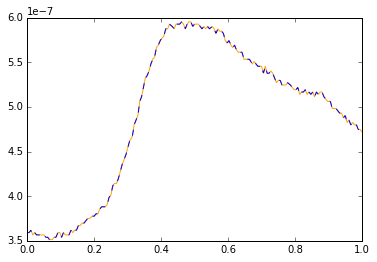

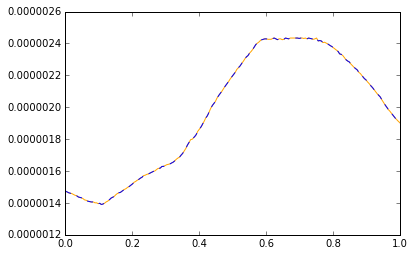

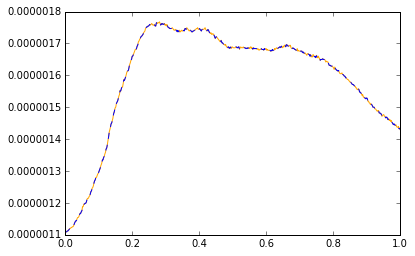

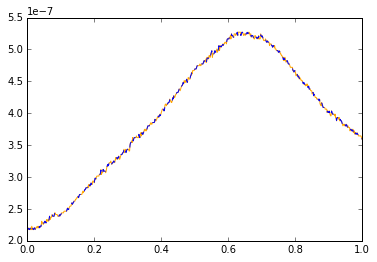

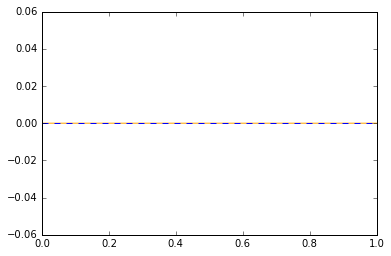

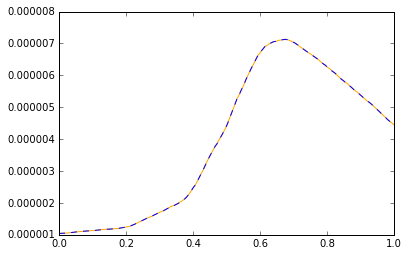

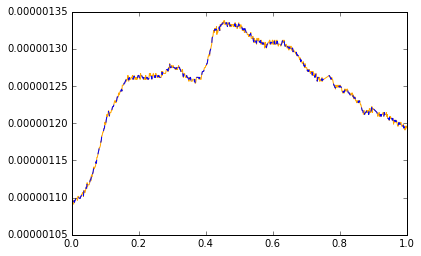

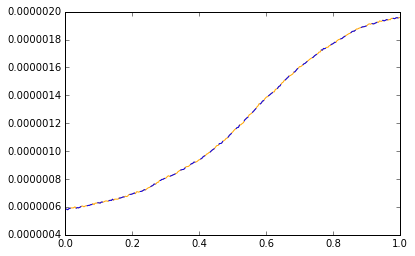

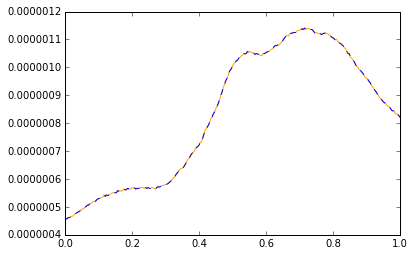

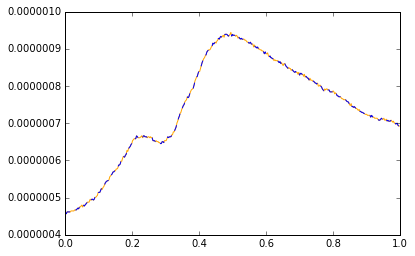

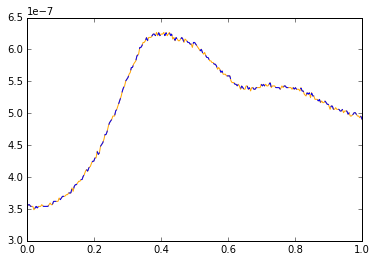

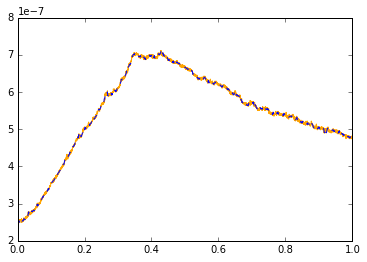

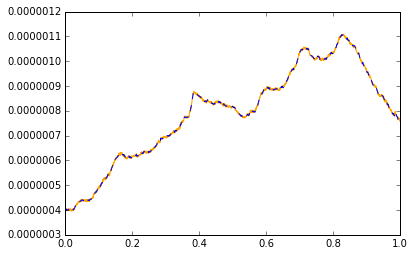

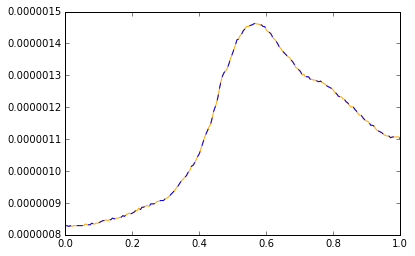

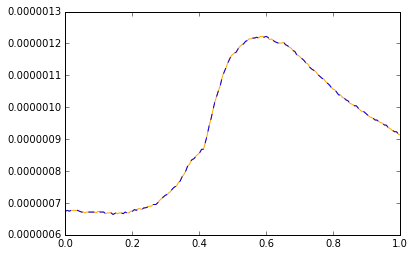

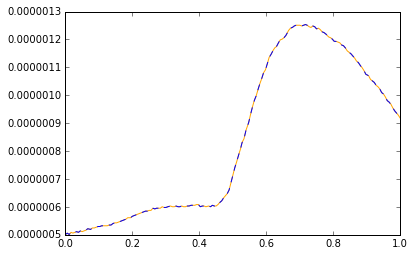

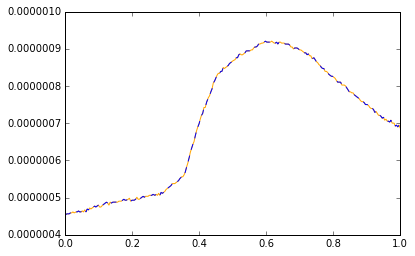

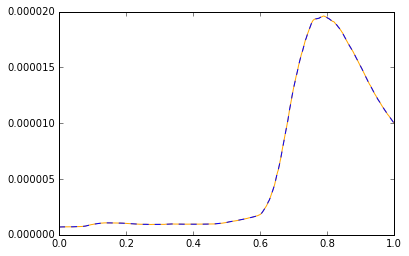

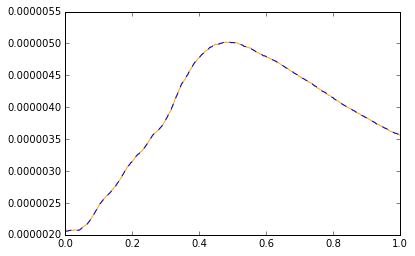

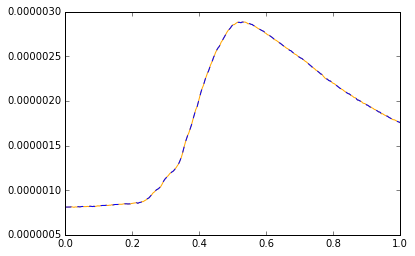

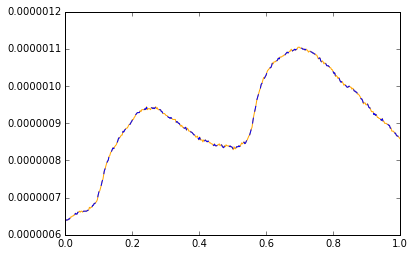

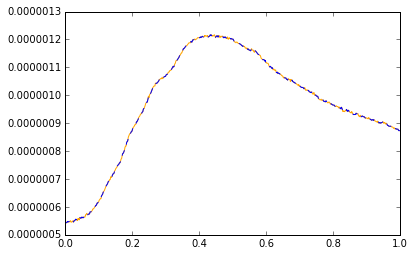

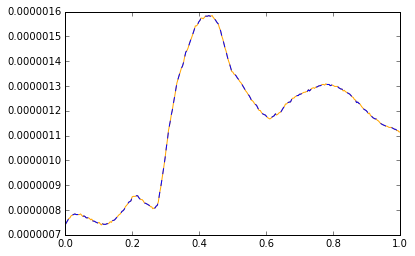

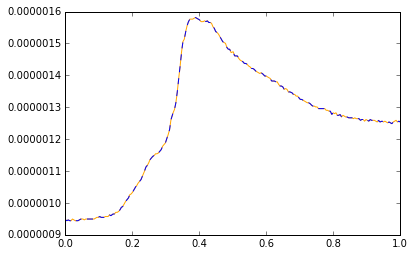

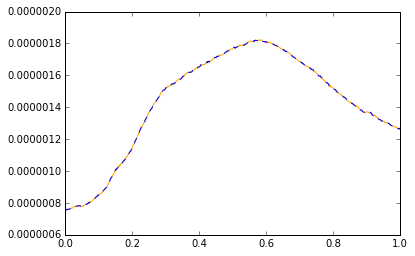

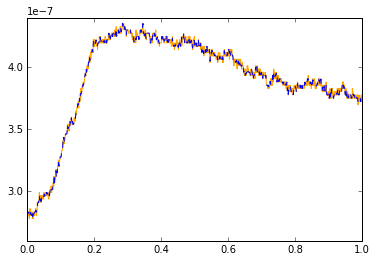

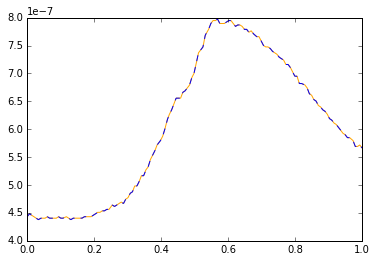

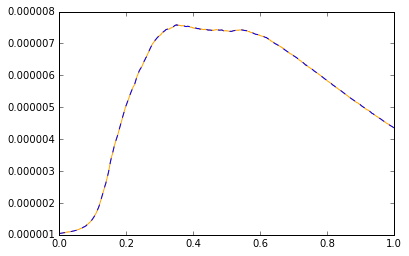

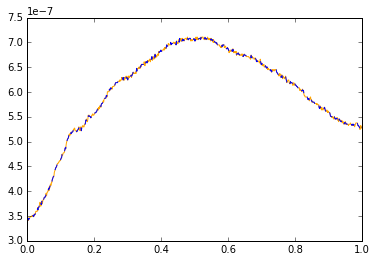

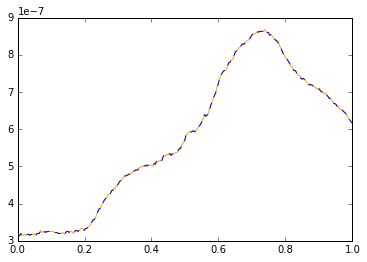

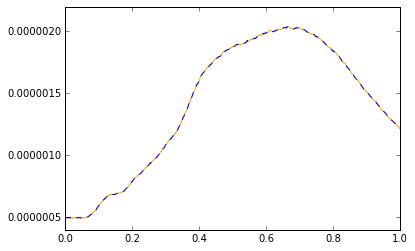

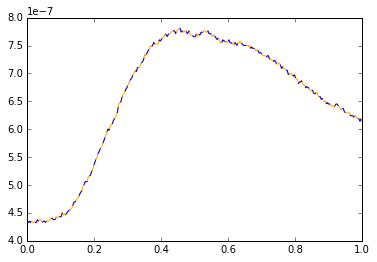

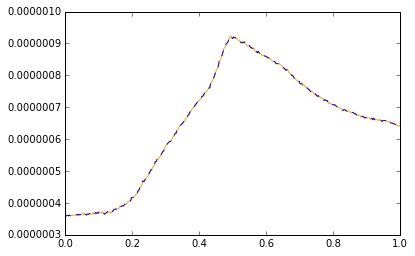

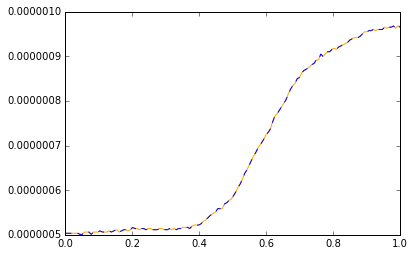

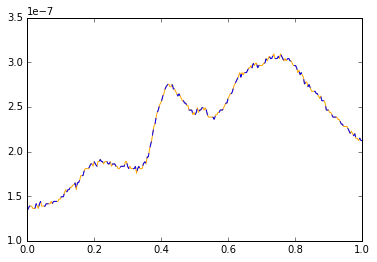

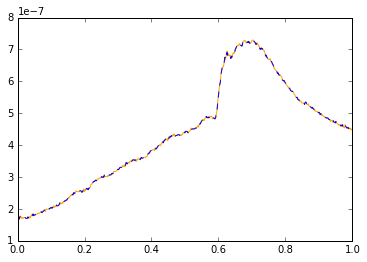

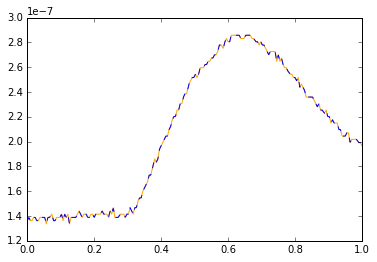

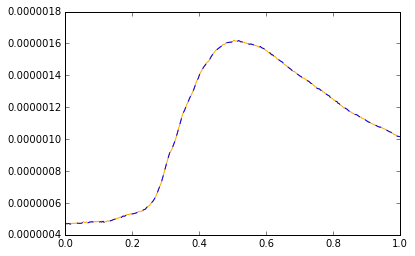

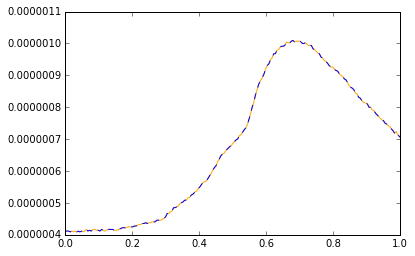

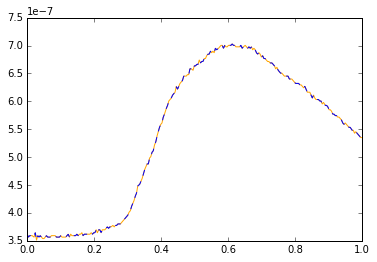

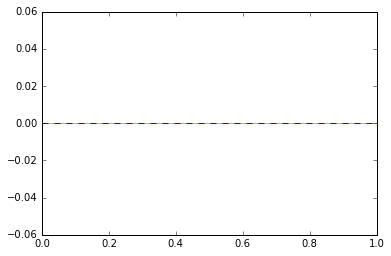

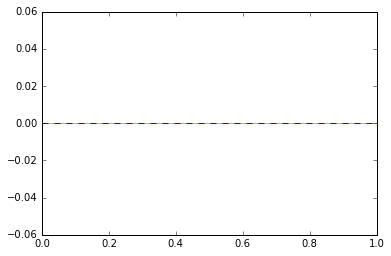

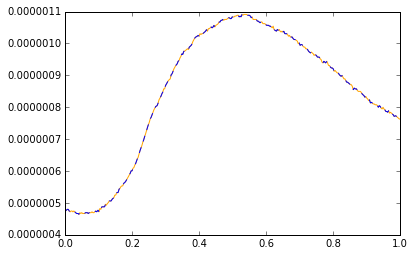

In [58]:
xset = []
for root, dirs, files in os.walk('sklearn_goes_train_lc'):
    for f in files:
        if f[0] != '.':
            inputFile = 'sklearn_goes_train_lc' +'/'+f
            lc = pd.read_csv(inputFile, delimiter = ',', header=0)
            lc['date'] = map(parse_time, lc['date'])
            minutesX = ((lc['date'] - lc['date'].values[0])*10**(-9))
            minutesX = map(lambda x: x/np.timedelta64(1, 'ns'), minutesX)
            duration = minutesX[-1]
            pctX = minutesX/duration
            f = interpolate.interp1d(pctX, lc['xrsb'])
            standardpct = np.linspace(0, 1, 750)
            standardLC = f(standardpct)
            xset.append(standardLC)
#             plt.plot(pctX, lc['xrsb'], color ='orange')
#             plt.plot(standardpct, standardLC, color='b', ls='--')
#             plt.show()


745.681372549
88
7501


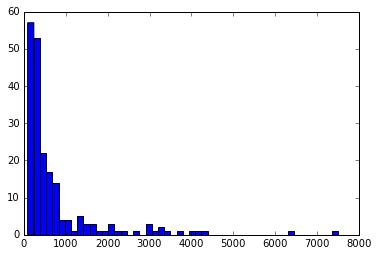

In [37]:
totalsum = 0
lengths = []
for i in range(204):
    length = len(xset[i])
    lengths.append(length)
    totalsum += length
avglen = totalsum/204.0
print avglen
plt.hist(lengths, bins=50)
print min(lengths)
print max(lengths)

In [26]:
yset = pd.read_csv('sklearn_goes1.csv', delimiter=',', header=0)
y = yset['verdict']

In [72]:
xtrain, xtest, ytrain, ytest = sklearn.cross_validation.train_test_split(
    xset, y, test_size=0.2, random_state = 5)

In [ ]:
clf = svm.SVC(decision_function_shape='ovo')
fitted = clf.fit(xtrain, ytrain)
predicted = clf.predict(xtest)

classif_rate = np.mean(predicted.ravel() == ytest.ravel()) * 100
metrics = metrics.classification_report(ytest, predicted)
score = svm.SVC.score(xtest, ytest)

print fitted
print predicted
print ytest.values
print classif_rate
print metrics
print score
